## Open the Dataset

In [17]:
import pandas as pd
import numpy as np

file_path = '/scratch/mch/fackerma/orders/TRT_modelsetup_3/Model_Setup_3_b.pkl'

df = pd.read_pickle(file_path)


exclude_cols = ['traj_ID', 'yyyymmddHHMM', 'Gust_Flag', 'STA_Marker', 'CS_Marker', 'ESWD_Marker', 'geometry']

for col in df.columns:
    if col not in exclude_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')



df['Z_top_smoothness'] = df['ZH_20_height'] - df['ZH_45_height'] 

df['CoreAspect_ratio'] = df['ZH_45_height'] / df['area']

df['wDraft'] = (-3.1 * 10**-6 * df['ZH_20_height'] + 20.6*df['VIL'])**0.5


/tmp/ipykernel_228591/308785774.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Z_top_smoothness'] = df['ZH_20_height'] - df['ZH_45_height']
/tmp/ipykernel_228591/308785774.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CoreAspect_ratio'] = df['ZH_45_height'] / df['area']
/tmp/ipykernel_228591/308785774.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [20]:
# Print all column names as a list
print(list(df.columns))



['geometry', 'Age', 'CS Marker', 'STA Marker', 'ESWD Marker', 'STA Speed', 'Gust_Flag', 'time', 'traj_ID', 'yyyymmddHHMM', 'lon', 'lat', 'ell_L', 'ell_S', 'ell_or', 'area', 'vel_x', 'vel_y', 'det', 'RANKr', 'CG-', 'CG+', 'CG', '%CG+', 'ET45', 'ET45m', 'ET15', 'ET15m', 'VIL', 'maxH', 'maxHm', 'POH', 'MESHS', 'Dvel_x', 'Dvel_y', 'chx', 'chy', 'VILD', 'POHm3', 'POH90', 'POH75', 'nrPOH', 'nrPOH90', 'nrPOH75', 'MESHSm3', 'MESHS90', 'MESHS75', 'nrMESHS', 'nrMESHS90', 'nrMESHS75', 'HZTm3', 'HZT90', 'HZT75', 'D_HZT', 'dBZmax', 'dBZm3', 'dBZ90', 'dBZ75', 'nrdBZ90', 'nrdBZ75', 'area45', 'area57', 'IC', 'L_TOT', 'RRm3', 'RR90', 'RR75', 'nrRR90', 'nrRR75', 'IR108max', 'IR108med', 'IR108min', 'nrMESHSthr20', 'nrMESHSthr25', 'nrMESHSthr30', 'nrMESHSthr35', 'nrMESHSthr40', 'nrMESHSthr45', 'nrMESHSthr50', 'nrMESHSthr55', 'nrMESHSthr60', 'nrPOHthr001', 'nrPOHthr010', 'nrPOHthr020', 'nrPOHthr030', 'nrPOHthr040', 'nrPOHthr050', 'nrPOHthr060', 'nrPOHthr070', 'nrPOHthr080', 'nrPOHthr090', 'nrPOHthr100', 't

## Investigate NaN values

In [ ]:
# Random probabilistic NA filling 
import numpy as np

# Columns to impute
columns_to_impute = ['IC', 'area45', 'area57', 'dBZmax']

for col in columns_to_impute:
    # Get non-NA values in the 'Yes' group for the current column
    yes_group = df[df['Gust_Flag'] == 'Yes']
    non_na_values = yes_group[col].dropna()
    
    if not non_na_values.empty:
        # Calculate probabilities for each unique value
        value_counts = non_na_values.value_counts(normalize=True)
        values = value_counts.index.tolist()
        probabilities = value_counts.values
        
        # Identify NA indices to fill
        na_mask = (df['Gust_Flag'] == 'Yes') & (df[col].isna())
        
        # Sample and fill
        df.loc[na_mask, col] = np.random.choice(
            values, 
            size=na_mask.sum(), 
            p=probabilities
        )

# Impute L_TOT with the sum of IC and CG where L_TOT is NA
na_mask = df['L_TOT'].isna()
df.loc[na_mask, 'L_TOT'] = df.loc[na_mask, 'IC'] + df.loc[na_mask, 'CG']

df.loc[df['KDP_com_height'] < 0, 'KDP_com_height'] = 0





In [23]:
# Iterative ML NA imputing
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer


# Select columns to impute
cols_to_impute = ['ZH_com_height', 'KDP_com_height','vel_x','vel_y','dBZmax','area45', 'area57','IC', 'rad_shear_max','ZH_45_height',
                  'ZH_20_height','ZH_95th_percentile_height', 'ZH_max_height','KDP_95th_percentile_height','KDP_max_height',
                  'rad_shear_95th_percentile_height', 'rad_shear_max_height', 'Z_top_smoothness','CoreAspect_ratio', 'VIL']  

# Extract the subset for imputation
X = df[cols_to_impute]

# Initialize the imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit and transform the data
X_imputed = imputer.fit_transform(X)

# Replace the original columns with imputed values
df[cols_to_impute] = X_imputed


df['velocity'] = np.sqrt(df['vel_x']**2 + df['vel_y']**2)

# Impute L_TOT with the sum of IC and CG where L_TOT is NA
na_mask = df['L_TOT'].isna()
df.loc[na_mask, 'L_TOT'] = df.loc[na_mask, 'IC'] + df.loc[na_mask, 'CG']

df.loc[df['KDP_com_height'] < 0, 'KDP_com_height'] = 0


df['Z_top_smoothness'] = df['ZH_20_height'] - df['ZH_45_height'] 

df['CoreAspect_ratio'] = df['ZH_45_height'] / df['area']

df['wDraft'] = (-3.1 * 10**-6 * df['ZH_20_height'] + 20.6*df['VIL'])**0.5

df['wDraft_pred_25'] = np.where(df['wDraft'] > 25, 'Yes', 'No')

/tmp/ipykernel_228591/943217417.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['velocity'] = np.sqrt(df['vel_x']**2 + df['vel_y']**2)
/tmp/ipykernel_228591/943217417.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wDraft_pred_25'] = np.where(df['wDraft'] > 25, 'Yes', 'No')


In [24]:
print(df['ZH_20_height'].describe())


count    32942.000000
mean        45.645194
std         13.372548
min          9.000000
25%         35.000000
50%         43.000000
75%         55.000000
max         88.000000
Name: ZH_20_height, dtype: float64


In [75]:
# Temporal refinements
import pandas as pd

# Ensure the column is in datetime format
df['yyyymmddHHMM'] = pd.to_datetime(df['yyyymmddHHMM'], format='%Y%m%d%H%M')  # specify format for efficiency[1][2][3][4][7]

# Filter to keep only rows where the month is less than or equal to 9 (September)
df = df[df['yyyymmddHHMM'].dt.month <= 9]


## Plot time series of Yes and No cells for a given feature

In [2]:
df_grouped = df.sort_values(['traj_ID', 'yyyymmddHHMM'])

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_mean_gust_flag_sequences(df, columns_to_plot, gust_flag_column='Gust_Flag'):
    """
    For each occurrence of 'Yes' or 'No' in gust_flag_column, extract the four-row sequence
    (that row and the three previous rows), only if none of the four rows contain NaNs in
    the columns to plot. Then, for each timestep (0-3), compute the mean for all 'Yes' and
    all 'No' sequences and plot them.
    """
    # Prepare storage for sequences
    sequences = {'Yes': {col: [] for col in columns_to_plot},
                 'No': {col: [] for col in columns_to_plot}}

    # Loop over all indices where Gust_Flag is 'Yes' or 'No'
    for flag in ['Yes', 'No']:
        indices = df.index[df[gust_flag_column] == flag].tolist()
        for idx in indices:
            if idx < 3:
                continue  # Not enough previous rows
            rows = df.iloc[idx-3:idx+1]
            # Check for NaNs in the relevant columns
            if rows[columns_to_plot].isna().any().any():
                continue  # Skip if any NaN found
            for col in columns_to_plot:
                sequences[flag][col].append(rows[col].values)

    # Compute mean for each timestep (0-3)
    x_vals = np.arange(4)
    plt.figure(figsize=(10, 6))
    color_map = {'Yes': 'red', 'No': 'blue'}
    for col in columns_to_plot:
        for flag in ['Yes', 'No']:
            data = np.array(sequences[flag][col])  # shape: (num_sequences, 4)
            if data.size == 0:
                continue  # No valid sequences
            mean_vals = np.mean(data, axis=0)
            plt.plot(
                x_vals, mean_vals, marker='o', color=color_map[flag],
                label=f"{col} ({flag})"
            )

    col_str = "_".join(columns_to_plot)
    filename = f"mean_gust_flag_{col_str}.png"
    plt.xlabel("Step (0=oldest, 3=Gust_Flag event)")
    plt.ylabel("Mean Value")
    plt.title("Mean Time Series for Gust_Flag = 'Yes' and 'No' (last 4 rows)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/users/fackerma/newproject1/figures/Model/{filename}")




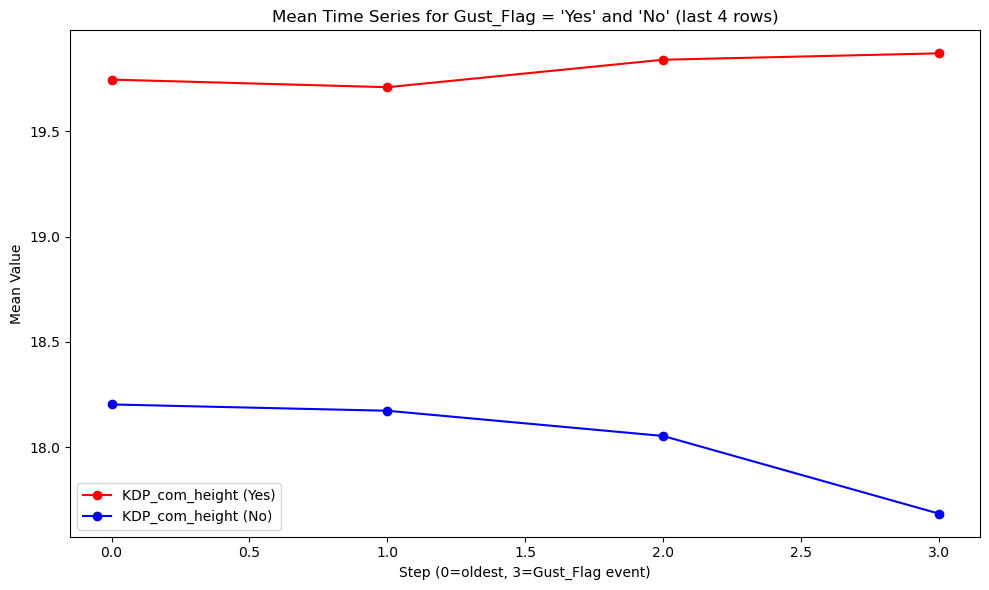

In [17]:
# Example usage:
plot_mean_gust_flag_sequences(
    df_grouped,
    columns_to_plot=['KDP_com_height'],  # replace with your column names
    gust_flag_column='Gust_Flag'
)

## Check, if Yes and No are spatially separated by 15 minutes for every cell

In [25]:
## Problemativ iDs are stored under problematic_ids


# Only keep rows where Gust_Flag is 'Yes' or 'No'
df_events = df[df['Gust_Flag'].isin(['Yes', 'No'])].copy()

# Ensure timestamp is a datetime type
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'])

# Helper function to check each traj_ID
def check_separation(group):
    # Sort by timestamp
    group = group.sort_values('timestamp')
    # Find indices where Gust_Flag changes
    flag_changes = group['Gust_Flag'] != group['Gust_Flag'].shift()
    change_indices = group.index[flag_changes].tolist()
    # For each transition, check the time difference
    for i in range(1, len(change_indices)):
        idx_prev = change_indices[i-1]
        idx_curr = change_indices[i]
        t_prev = group.loc[idx_prev, 'timestamp']
        t_curr = group.loc[idx_curr, 'timestamp']
        # If the time difference is less than 15 minutes, return False
        if (t_curr - t_prev).total_seconds() < 15*60:
            return False
    return True

# Find traj_IDs with both 'Yes' and 'No'
traj_ids_with_both = df_events.groupby('traj_ID')['Gust_Flag'].nunique()
traj_ids_with_both = traj_ids_with_both[traj_ids_with_both == 2].index

# Check each of these traj_IDs
problematic_ids = []
for traj_id in traj_ids_with_both:
    group = df_events[df_events['traj_ID'] == traj_id]
    if not check_separation(group):
        problematic_ids.append(traj_id)

if problematic_ids:
    print("The following traj_IDs do NOT fulfill the 15-minute separation criterion:")
    print(problematic_ids)
else:
    print("All traj_IDs fulfill the 15-minute separation criterion.")


The following traj_IDs do NOT fulfill the 15-minute separation criterion:
['2022050312350084', '2022051914300101', '2022052313050033', '2022060513150023', '2022060814050036', '2022060912000027', '2022062218200047', '2022062318250014', '2022070317250043', '2022072814400003', '2022080516350220', '2022080517000195', '2022080518100153', '2022081219350026', '2022081513200137', '2022082614250035', '2022083018350162', '2022090308400009', '2022091416450031', '2022102413400069', '2023050515150008', '2023050515250074', '2023050712200125', '2023062017350029', '2023071119050090', '2023071203500061', '2023071519000155', '2023071810050092', '2023072111200038', '2023072323550045', '2023072405500180', '2023072511050088', '2023072516450002', '2023072912300020', '2023081313550088', '2023081314200026', '2023082518100162', '2023082609500037', '2023091815250026']


In [26]:
# Exclude problematic IDs (replace with your list) or not...

# Originalen DataFrame aktualisieren (nicht df_events!)
#df.loc[
 #   (df['traj_ID'].isin(problematic_ids)) & 
 #   (df['Gust_Flag'] == 'No'),  # Bedingung: Nur 'No'-Einträge
#    'Gust_Flag'  # Spalte auswählen
#] = '-'  # Ersetzung


#filtered_df = df
filtered_df = df[~df['traj_ID'].isin(problematic_ids)]

# Get unique traj_IDs
unique_ids = filtered_df['traj_ID'].unique()

## Make the split

In [27]:
# 1. Modify Your Splitting to Use Stratification
# ---------------------------------------------
from sklearn.model_selection import train_test_split

# First split: train and temp (70%/30%) WITH STRATIFICATION
train_ids, temp_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    stratify=filtered_df.groupby('traj_ID')['Gust_Flag'].first(),  # Stratify by storm outcome
    random_state=42
)

# Second split: test (20%) and validation (10%) WITH STRATIFICATION
test_ids, val_ids = train_test_split(
    temp_ids,
    test_size=0.333,
    stratify=filtered_df[filtered_df['traj_ID'].isin(temp_ids)].groupby('traj_ID')['Gust_Flag'].first(),
    random_state=42
)

In [331]:
# No stratification
from sklearn.model_selection import train_test_split

# First split: train and temp (70%/30%)
train_ids, temp_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    random_state=42
)

# Second split: test (20% of total) and validation (10% of total)
test_ids, val_ids = train_test_split(
    temp_ids,
    test_size=0.333,  # 10% / 30% ≈ 0.333
    random_state=42
)


In [344]:
# Stratifiy by majority 'Gust_Flag' for unique_ids

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold


# Get the majority Gust_Flag per traj_ID
majority_flags = filtered_df.groupby('traj_ID')['Gust_Flag'].agg(lambda x: x.mode()[0])  # with '-'

train_ids, temp_ids = train_test_split(
    unique_ids, 
    test_size=0.3, 
    stratify=majority_flags,
    random_state=42
)

# Split temp into test (20% of total) and validation (10% of total)
test_ids, val_ids = train_test_split(
    temp_ids, 
    test_size=0.333,  # 10% / 30% ≈ 0.333
    random_state=42
)




In [356]:
# Stratify by majority 'Gust_Flag' only 'Yes' and 'No' for unique_ids

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold

# Get unique traj_IDs
unique_ids = filtered_df['traj_ID'].unique()

# Get the majority Gust_Flag per traj_ID, excluding '-'
def get_majority_ignore_dash(series):
    filtered = series[series != '-']  # Remove '-' entries
    if filtered.empty:
        return '-'  # Fallback if all values are '-'
    else:
        return filtered.mode()[0]  # Majority of remaining values



majority_flags = filtered_df.groupby('traj_ID')['Gust_Flag'].agg(get_majority_ignore_dash) # without '0'

# Split into train/test/val
train_ids, temp_ids = train_test_split(
    unique_ids,
    test_size=0.3,
    stratify=majority_flags.loc[unique_ids],  # Use filtered majority_flags
    random_state=42
)

test_ids, val_ids = train_test_split(
    temp_ids,
    test_size=0.333,
    stratify=majority_flags.loc[temp_ids],  # Optional: Stratify here too if needed
    random_state=42
)



ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [377]:
# Stratify by the relation of absolute 'Yes' and 'No' rows, but still split the unique_ids


# Count 'Yes' and 'No' per traj_ID
count_df = filtered_df[filtered_df['Gust_Flag'].isin(['Yes', 'No'])] \
    .groupby('traj_ID')['Gust_Flag'] \
    .value_counts() \
    .unstack(fill_value=0) \
    .reset_index()


from sklearn.model_selection import train_test_split
import numpy as np

unique_ids = count_df['traj_ID'].values
yes_counts = count_df['Yes'].values
no_counts = count_df['No'].values

# For stratification, create a 2D array of [yes_count, no_count] for each traj_ID
stratify_labels = np.array([yes_counts, no_counts]).T


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Prepare the stratification matrix (each row: [yes_count, no_count])
X = unique_ids.reshape(-1, 1)  # features (not used, but required)
y = stratify_labels            # labels for stratification

# Split into train (70%) and temp (30%)
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
splits = list(mskf.split(X, y))

# Get indices for the first fold as test, rest as train
train_indices, temp_indices = splits[0][0], splits[0][1]

train_ids = unique_ids[train_indices]
temp_ids = unique_ids[temp_indices]

# Now split temp into test (2/3) and val (1/3) using the same method
temp_X = temp_ids.reshape(-1, 1)
temp_y = stratify_labels[temp_indices]

mskf_temp = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)
splits_temp = list(mskf_temp.split(temp_X, temp_y))

test_indices, val_indices = splits_temp[0][0], splits_temp[0][1]

test_ids = temp_ids[test_indices]
val_ids = temp_ids[val_indices]




In [369]:
# Compute with having an overall balanced 'Yes' to 'No' ratio in every split for unique_ids (70,20,10)

import pandas as pd
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Example: filtered_df is your DataFrame

# Only keep rows with 'Yes' or 'No'
filtered_flags = filtered_df[filtered_df['Gust_Flag'].isin(['Yes', 'No'])]

# Count 'Yes' and 'No' per traj_ID
count_df = (
    filtered_flags
    .groupby('traj_ID')['Gust_Flag']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Ensure both columns exist
for flag in ['Yes', 'No']:
    if flag not in count_df.columns:
        count_df[flag] = 0

unique_ids = count_df['traj_ID'].values
stratify_labels = count_df[['Yes', 'No']].values

# Compute the ratio
total_yes = count_df['Yes'].sum()
total_no = count_df['No'].sum()
overall_ratio = total_yes / total_no if total_no > 0 else 0
print(f"Overall Yes:No ratio = {total_yes}:{total_no} ({overall_ratio:.3f})")

N = len(unique_ids)
train_size = int(N * 0.7)
temp_size = N - train_size

# First split: train vs temp
sss1 = MultilabelStratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=temp_size, random_state=42)
train_idx, temp_idx = next(sss1.split(unique_ids.reshape(-1, 1), stratify_labels))

train_ids = unique_ids[train_idx]
temp_ids = unique_ids[temp_idx]
temp_labels = stratify_labels[temp_idx]

# Second split: test vs val within temp
temp_N = len(temp_ids)
test_size = int(temp_N * 2/3)
val_size = temp_N - test_size

sss2 = MultilabelStratifiedShuffleSplit(n_splits=1, train_size=test_size, test_size=val_size, random_state=42)
test_idx, val_idx = next(sss2.split(temp_ids.reshape(-1, 1), temp_labels))

test_ids = temp_ids[test_idx]
val_ids = temp_ids[val_idx]



Overall Yes:No ratio = 2062:5352 (0.385)


## Map the split back to the dataset

In [28]:
import numpy as np

# Suppose val_ids, train_ids, test_ids are numpy arrays
val_ids = np.array(val_ids)
train_ids = np.array(train_ids)
test_ids = np.array(test_ids)

manual_traj_ids = set(['2019061509450011.0','2021071217550028.0','2021071221500035.0','2021071305200023.0','2022063019350162','2023082417300207'])

# Convert arrays to sets
val_ids_set = set(val_ids)
train_ids_set = set(train_ids)
test_ids_set = set(test_ids)

# Add to validation set
val_ids_set = val_ids_set.union(manual_traj_ids)

# Remove from train and test sets
train_ids_set = train_ids_set - manual_traj_ids
test_ids_set = test_ids_set - manual_traj_ids

# Convert back to numpy arrays or lists if needed
val_ids = np.array(list(val_ids_set))
train_ids = np.array(list(train_ids_set))
test_ids = np.array(list(test_ids_set))


# Map IDs back to full dataframe
train_df = filtered_df[filtered_df['traj_ID'].isin(train_ids)]
test_df = filtered_df[filtered_df['traj_ID'].isin(test_ids)]
val_df = filtered_df[filtered_df['traj_ID'].isin(val_ids)]

train_df = train_df.sort_values(['traj_ID', 'yyyymmddHHMM'])
test_df = test_df.sort_values(['traj_ID', 'yyyymmddHHMM'])
val_df = val_df.sort_values(['traj_ID', 'yyyymmddHHMM'])

# Function to print stats for each split
def print_split_stats(df, name):
    total = len(df)
    unique_ids = df['traj_ID'].nunique()
    yes_count = (df['Gust_Flag'] == 'Yes').sum()
    no_count = (df['Gust_Flag'] == 'No').sum()
    ratio = yes_count / no_count if no_count > 0 else float('inf')
    print(f"{name}:")
    print(f"  Number of rows: {total}")
    print(f"  Number of unique traj_IDs: {unique_ids}")
    print(f"  'Yes' count: {yes_count}")
    print(f"  'No' count: {no_count}")
    print(f"  'Yes':'No' ratio: {yes_count}:{no_count} ({ratio:.3f})")
    print("-" * 40)

# Only keep rows with 'Yes' or 'No'
filtered_flags = filtered_df[filtered_df['Gust_Flag'].isin(['Yes', 'No'])]
# Count 'Yes' and 'No' per traj_ID
count_df = (
    filtered_flags
    .groupby('traj_ID')['Gust_Flag']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

def print_ratio(ids, count_df, name):
    subset = count_df[count_df['traj_ID'].isin(ids)]
    yes = subset['Yes'].sum()
    no = subset['No'].sum()
    ratio = yes / no if no > 0 else 0
    print(f"{name} - Yes:No = {yes}:{no} (ratio: {ratio:.3f})")


print_ratio(unique_ids, count_df, "Full")
print_split_stats(train_df, "Train")
print_split_stats(test_df, "Test")
print_split_stats(val_df, "Validation")


Full - Yes:No = 2062:5352 (ratio: 0.385)
Train:
  Number of rows: 22332
  Number of unique traj_IDs: 2449
  'Yes' count: 1330
  'No' count: 3722
  'Yes':'No' ratio: 1330:3722 (0.357)
----------------------------------------
Test:
  Number of rows: 6724
  Number of unique traj_IDs: 702
  'Yes' count: 425
  'No' count: 1107
  'Yes':'No' ratio: 425:1107 (0.384)
----------------------------------------
Validation:
  Number of rows: 3123
  Number of unique traj_IDs: 357
  'Yes' count: 307
  'No' count: 523
  'Yes':'No' ratio: 307:523 (0.587)
----------------------------------------


## Train and validate on custom Lags and Lag-Deltas

In [47]:
# 1. Define feature groups (MODIFIED)
features_no_lags = [#'area', 
                    #'RANKr', 
                    #'dBZmax', 
                    #'velocity', 
                    #'VIL', 
                    #'Age', 
                    #'area45',
                    #'area57',
                    #'POH', 
                    #'MESHS',
                    'CG',
                    #'%CG+',
                    'IC', 
                    'L_TOT',
                    #'rad_shear_max', 
                    'rad_shear_max_height', 
                    #'rad_shear_95th_percentile', 
                    #'rad_shear_95th_percentile_height',
                    'rad_shear_percent_above_2.5', 
                    'rad_shear_percent_above_2', 
                    'rad_shear_percent_above_1.5', 
                    'rad_shear_percent_above_1', 
                    'rad_shear_percent_above_0.5',
                    'ZH_com_height', 
                    #'ZH_max', 
                    #'ZH_max_height', 
                    #'ZH_95th_percentile', 
                    #'ZH_95th_percentile_height', 
                    #'ZH_percent_above_55', 
                    #'ZH_percent_above_50', 
                    'ZH_percent_above_45', 
                    'ZH_percent_above_40', 
                    'ZH_percent_above_35', 
                    #'ZH_percent_above_30',
                    'ZH_45_height', 
                    #'ZH_20_height', 
                    #'Z_top_smoothness', 
                    #'CoreAspect_ratio', 
                    #'KDP_com_height', 
                    #'KDP_max', 
                    #'KDP_max_height', 
                    #'KDP_95th_percentile', 
                    #'KDP_95th_percentile_height',
                    'KDP_percent_above_2', 
                    'KDP_percent_above_1.5', 
                    'KDP_percent_above_1', 
                    'KDP_percent_above_0.5'
                    ]   
features_lags_only = [#'area', 
                    #'RANKr', 
                    #'dBZmax', 
                    #'velocity', 
                    #'VIL', 
                    #'Age', 
                    #'area45',
                    #'area57',
                    #'POH', 
                    #'MESHS',
                    #'CG', 
                    'IC', 
                    'L_TOT',
                    #'rad_shear_max', 
                    #'rad_shear_max_height', 
                    #'rad_shear_95th_percentile', 
                    #'rad_shear_95th_percentile_height',
                    #'rad_shear_percent_above_2.5', 
                    #'rad_shear_percent_above_2', 
                    #'rad_shear_percent_above_1.5', 
                    #'rad_shear_percent_above_1', 
                    #'rad_shear_percent_above_0.5',
                    #'ZH_com_height', 
                    #'ZH_max', 
                    #'ZH_max_height', 
                    #'ZH_95th_percentile', 
                    #'ZH_95th_percentile_height', 
                    #'ZH_percent_above_55', 
                    #'ZH_percent_above_50', 
                    #'ZH_percent_above_45', 
                    #'ZH_percent_above_40', 
                    #'ZH_percent_above_35', 
                    #'ZH_percent_above_30',
                    #'ZH_45_height', 
                    #'ZH_20_height', 
                    #'Z_top_smoothness', 
                    #'CoreAspect_ratio', 
                    #'KDP_com_height', 
                    #'KDP_max', 
                    #'KDP_max_height', 
                    #'KDP_95th_percentile', 
                    #'KDP_95th_percentile_height',
                    #'KDP_percent_above_2', 
                    #'KDP_percent_above_1.5', 
                    #'KDP_percent_above_1', 
                    #'KDP_percent_above_0.5', 
                    ] 
features_lags_deltas = [#'area', 
                    #'RANKr', 
                    #'dBZmax', 
                    #'velocity', 
                    #'VIL', 
                    #'Age', 
                    #'POH', 
                    #'MESHS',
                    #'CG', 
                    #'IC', 
                    #'L_TOT',
                    #'rad_shear_max', 
                    #'rad_shear_max_height', 
                    #'rad_shear_95th_percentile', 
                    #'rad_shear_95th_percentile_height',
                    #'rad_shear_percent_above_2.5', 
                    #'rad_shear_percent_above_2', 
                    #'rad_shear_percent_above_1.5', 
                    #'rad_shear_percent_above_1', 
                    #'rad_shear_percent_above_0.5',
                    #'ZH_com_height', 
                    #'ZH_max', 
                    #'ZH_max_height', 
                    #'ZH_95th_percentile', 
                    #'ZH_95th_percentile_height', 
                    #'ZH_percent_above_55', 
                    #'ZH_percent_above_50', 
                    #'ZH_percent_above_45', 
                    #'ZH_percent_above_40', 
                    #'ZH_percent_above_35', 
                    #'ZH_percent_above_30',
                    #'ZH_45_height', 
                    #'ZH_20_height', 
                    #'Z_top_smoothness', 
                    #'CoreAspect_ratio', 
                    #'KDP_com_height', 
                    #'KDP_max', 
                    #'KDP_max_height', 
                    #'KDP_95th_percentile', 
                    #'KDP_95th_percentile_height',
                    #'KDP_percent_above_2', 
                    #'KDP_percent_above_1.5', 
                    #'KDP_percent_above_1', 
                    #'KDP_percent_above_0.5', 
                    ] 

In [48]:
# Do feature optimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 2. Create lagged features (MODIFIED)
# For groups that need lags (Groups 2 & 3)
for feature in features_lags_only:
    for lag in range(1, 4):
        train_df[f'{feature}_lag{lag}'] = train_df.groupby('traj_ID')[feature].shift(lag)
        val_df[f'{feature}_lag{lag}'] = val_df.groupby('traj_ID')[feature].shift(lag)
        test_df[f'{feature}_lag{lag}'] = test_df.groupby('traj_ID')[feature].shift(lag)

for feature in features_lags_deltas:
    for lag in range(1, 4):
        train_df[f'{feature}_lag{lag}'] = train_df.groupby('traj_ID')[feature].shift(lag)
        val_df[f'{feature}_lag{lag}'] = val_df.groupby('traj_ID')[feature].shift(lag)
        test_df[f'{feature}_lag{lag}'] = test_df.groupby('traj_ID')[feature].shift(lag)


# 3. Create delta features (MODIFIED: Only for Group 3)
for feature in features_lags_deltas:
    train_df[f'{feature}_delta1'] = train_df[f'{feature}_lag1'] - train_df[f'{feature}']
    val_df[f'{feature}_delta1'] = val_df[f'{feature}_lag1'] - val_df[f'{feature}']
    test_df[f'{feature}_delta1'] = test_df[f'{feature}_lag1'] - test_df[f'{feature}']
    train_df[f'{feature}_delta2'] = train_df[f'{feature}_lag2'] - train_df[f'{feature}_lag1']
    val_df[f'{feature}_delta2'] = val_df[f'{feature}_lag2'] - val_df[f'{feature}_lag1']
    test_df[f'{feature}_delta2'] = test_df[f'{feature}_lag2'] - test_df[f'{feature}_lag1']
    train_df[f'{feature}_delta3'] = train_df[f'{feature}_lag3'] - train_df[f'{feature}_lag2']
    val_df[f'{feature}_delta3'] = val_df[f'{feature}_lag3'] - val_df[f'{feature}_lag2']
    test_df[f'{feature}_delta3'] = test_df[f'{feature}_lag3'] - test_df[f'{feature}_lag2']


# 4. Filter rows and prepare features (MODIFIED)
all_features = (
    features_no_lags +
    features_lags_only +
    [f'{f}_lag{l}' for f in features_lags_only for l in range(1, 4)] +
    features_lags_deltas +
    [f'{f}_lag{l}' for f in features_lags_deltas for l in range(1, 4)] +
    [f'{f}_delta{d}' for f in features_lags_deltas for d in range(1, 4)]
)

train_df_events = train_df[train_df['Gust_Flag'].isin(['Yes', 'No'])].copy()
val_df_events = val_df[val_df['Gust_Flag'].isin(['Yes', 'No'])].copy()
test_df_events = test_df[test_df['Gust_Flag'].isin(['Yes', 'No'])].copy()

print(len(train_df_events))

# 5. Drop NaNs only for required features (MODIFIED)
val_df_events = val_df_events.dropna(how='any', subset=all_features)
train_df_events = train_df_events.dropna(how='any', subset=all_features)
test_df_events = test_df_events.dropna(how='any', subset=all_features)

print(len(train_df_events))

#train_df_events = train_df_events.dropna(subset=all_features)
#val_df_events = val_df_events.dropna(subset=all_features)

# New (drops if ALL features are NaN)

5052
2962


In [49]:

all_features = list(dict.fromkeys(all_features))

#all_features.remove('L_TOT_lag1')
#all_features.remove('IC_lag1')

all_features

['CG',
 'IC',
 'L_TOT',
 'rad_shear_max_height',
 'rad_shear_percent_above_2.5',
 'rad_shear_percent_above_2',
 'rad_shear_percent_above_1.5',
 'rad_shear_percent_above_1',
 'rad_shear_percent_above_0.5',
 'ZH_com_height',
 'ZH_percent_above_45',
 'ZH_percent_above_40',
 'ZH_percent_above_35',
 'ZH_45_height',
 'KDP_percent_above_2',
 'KDP_percent_above_1.5',
 'KDP_percent_above_1',
 'KDP_percent_above_0.5',
 'IC_lag1',
 'IC_lag2',
 'IC_lag3',
 'L_TOT_lag1',
 'L_TOT_lag2',
 'L_TOT_lag3']

#### SMOTE class balancing & feature interpolation

Validation results:
              precision    recall  f1-score   support

          No       0.91      0.92      0.92       237
         Yes       0.91      0.89      0.90       207

    accuracy                           0.91       444
   macro avg       0.91      0.91      0.91       444
weighted avg       0.91      0.91      0.91       444

POD (Probability of Detection): 0.89
FAR (False Alarm Ratio): 0.09
CSI (Critical Success Index): 0.82
Test results:
              precision    recall  f1-score   support

          No       0.89      0.93      0.91       527
         Yes       0.87      0.81      0.84       321

    accuracy                           0.88       848
   macro avg       0.88      0.87      0.88       848
weighted avg       0.88      0.88      0.88       848

POD (Probability of Detection): 0.81
FAR (False Alarm Ratio): 0.13
CSI (Critical Success Index): 0.73


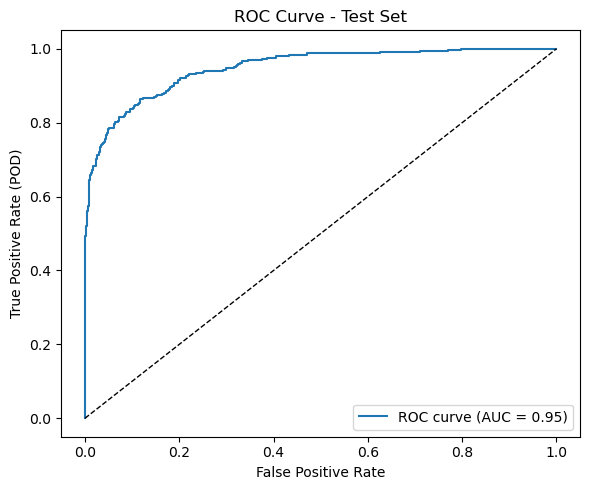

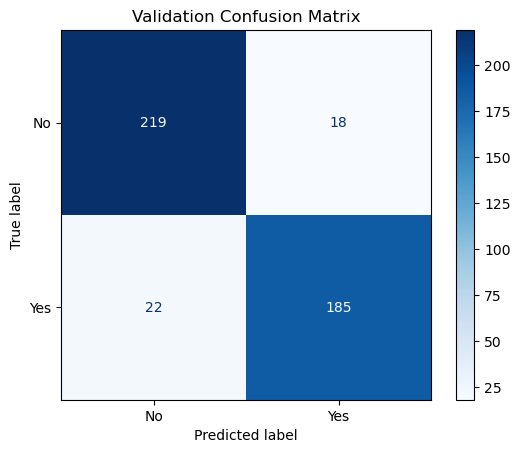

/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


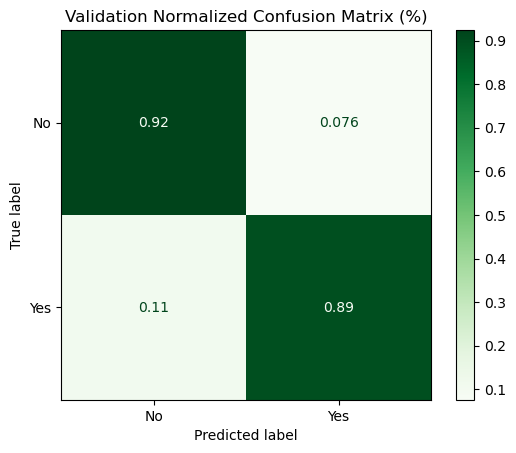

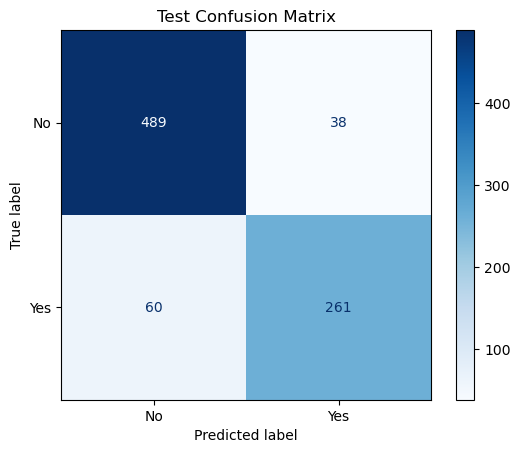

/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


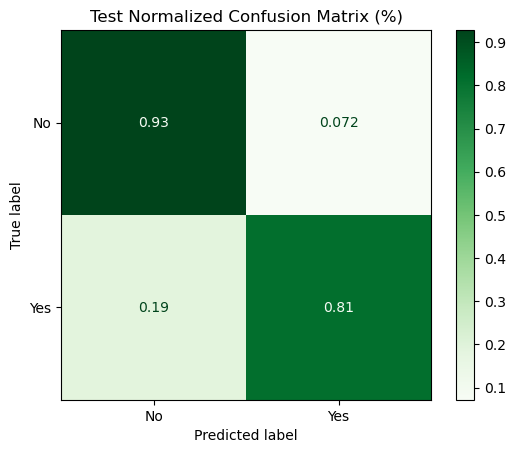

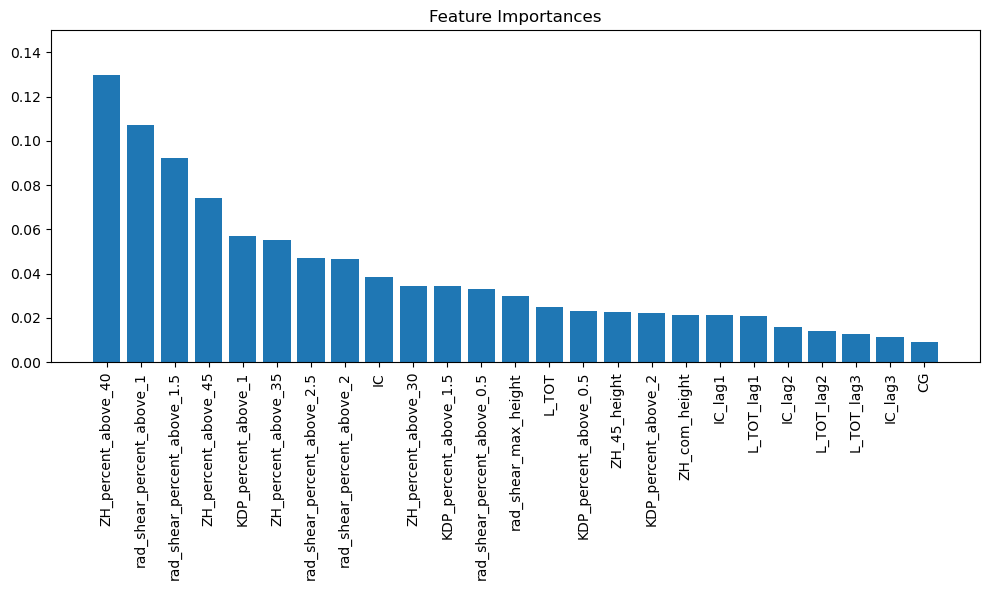

In [391]:
# Run this for SMOTE class balancing
from sklearn.impute import SimpleImputer

# Prepare feature matrices and target arrays
X_train = train_df_events[all_features]
y_train = train_df_events['Gust_Flag']

X_val = val_df_events[all_features]
y_val = val_df_events['Gust_Flag']

X_test = test_df_events[all_features]
y_test = test_df_events['Gust_Flag']


# Create the imputer (mean strategy is common for meteorological data)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the data 
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=0.9, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_imputed, y_train)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(class_weight='balanced', 
                               n_estimators=150, 
                               max_features="log2", 
                               max_depth=15, 
                               max_leaf_nodes = None,
                               #max_sample = None,
                               #min_sample_split = 2
                                )

#model = RandomForestClassifier(class_weight='balanced')
#model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_res, y_train_res)

# Validation
y_val_pred = model.predict(X_val_imputed)
print("Validation results:")
print(classification_report(y_val, y_val_pred))


# Compute confusion matrix for validation set
cm = confusion_matrix(y_val, y_val_pred, labels=['Yes', 'No'])
a = cm[0, 0]  # True Positives (Yes/Yes)
b = cm[1, 0]  # False Positives (No/Yes)
c = cm[0, 1]  # False Negatives (Yes/No)
d = cm[1, 1]  # True Negatives (No/No)

# Calculate metrics
POD = a / (a + c) if (a + c) > 0 else 0
FAR = b / (a + b) if (a + b) > 0 else 0
CSI = a / (a + b + c) if (a + b + c) > 0 else 0

print(f"POD (Probability of Detection): {POD:.2f}")
print(f"FAR (False Alarm Ratio): {FAR:.2f}")
print(f"CSI (Critical Success Index): {CSI:.2f}")

# Test
y_test_pred = model.predict(X_test_imputed)
print("Test results:")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred, labels=['Yes', 'No'])
a = cm[0, 0]  # True Positives (Yes/Yes)
b = cm[1, 0]  # False Positives (No/Yes)
c = cm[0, 1]  # False Negatives (Yes/No)
d = cm[1, 1]  # True Negatives (No/No)

# Calculate metrics
POD = a / (a + c) if (a + c) > 0 else 0
FAR = b / (a + b) if (a + b) > 0 else 0
CSI = a / (a + b + c) if (a + b + c) > 0 else 0

print(f"POD (Probability of Detection): {POD:.2f}")
print(f"FAR (False Alarm Ratio): {FAR:.2f}")
print(f"CSI (Critical Success Index): {CSI:.2f}")

# ROC Curve
y_test_binary = (y_test == 'Yes').astype(int)
y_score = model.predict_proba(X_test_imputed)[:, list(model.classes_).index('Yes')]

fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (POD)')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Validation confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
# Visualize with totals
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Remove 'd' for percentages
plt.title("Validation Confusion Matrix")
plt.show()

# Visualize with percentages
disp = ConfusionMatrixDisplay.from_estimator(
    model, 
    X_val, 
    y_val,
    normalize='true',  # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Validation Normalized Confusion Matrix (%)")
plt.show()



# Test confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
# Visualize with totals
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Remove 'd' for percentages
plt.title("Test Confusion Matrix")
plt.show()

# Visualize with percentages
disp = ConfusionMatrixDisplay.from_estimator(
    model, 
    X_test, 
    y_test,
    normalize='true',  # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Test Normalized Confusion Matrix (%)")
plt.show()



import numpy as np

# Get feature importances and sort them
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(all_features)

# Plot
plt.figure(figsize=(10,6))
plt.ylim(0, 0.15)
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


#### Ordinary training

Validation results:
              precision    recall  f1-score   support

          No       0.90      0.97      0.93       274
         Yes       0.97      0.88      0.92       257

    accuracy                           0.93       531
   macro avg       0.93      0.93      0.93       531
weighted avg       0.93      0.93      0.93       531

POD (Probability of Detection): 0.88
FAR (False Alarm Ratio): 0.03
CSI (Critical Success Index): 0.85
Test results:
              precision    recall  f1-score   support

          No       0.90      0.96      0.93       595
         Yes       0.92      0.82      0.87       353

    accuracy                           0.91       948
   macro avg       0.91      0.89      0.90       948
weighted avg       0.91      0.91      0.90       948

POD (Probability of Detection): 0.82
FAR (False Alarm Ratio): 0.08
CSI (Critical Success Index): 0.76


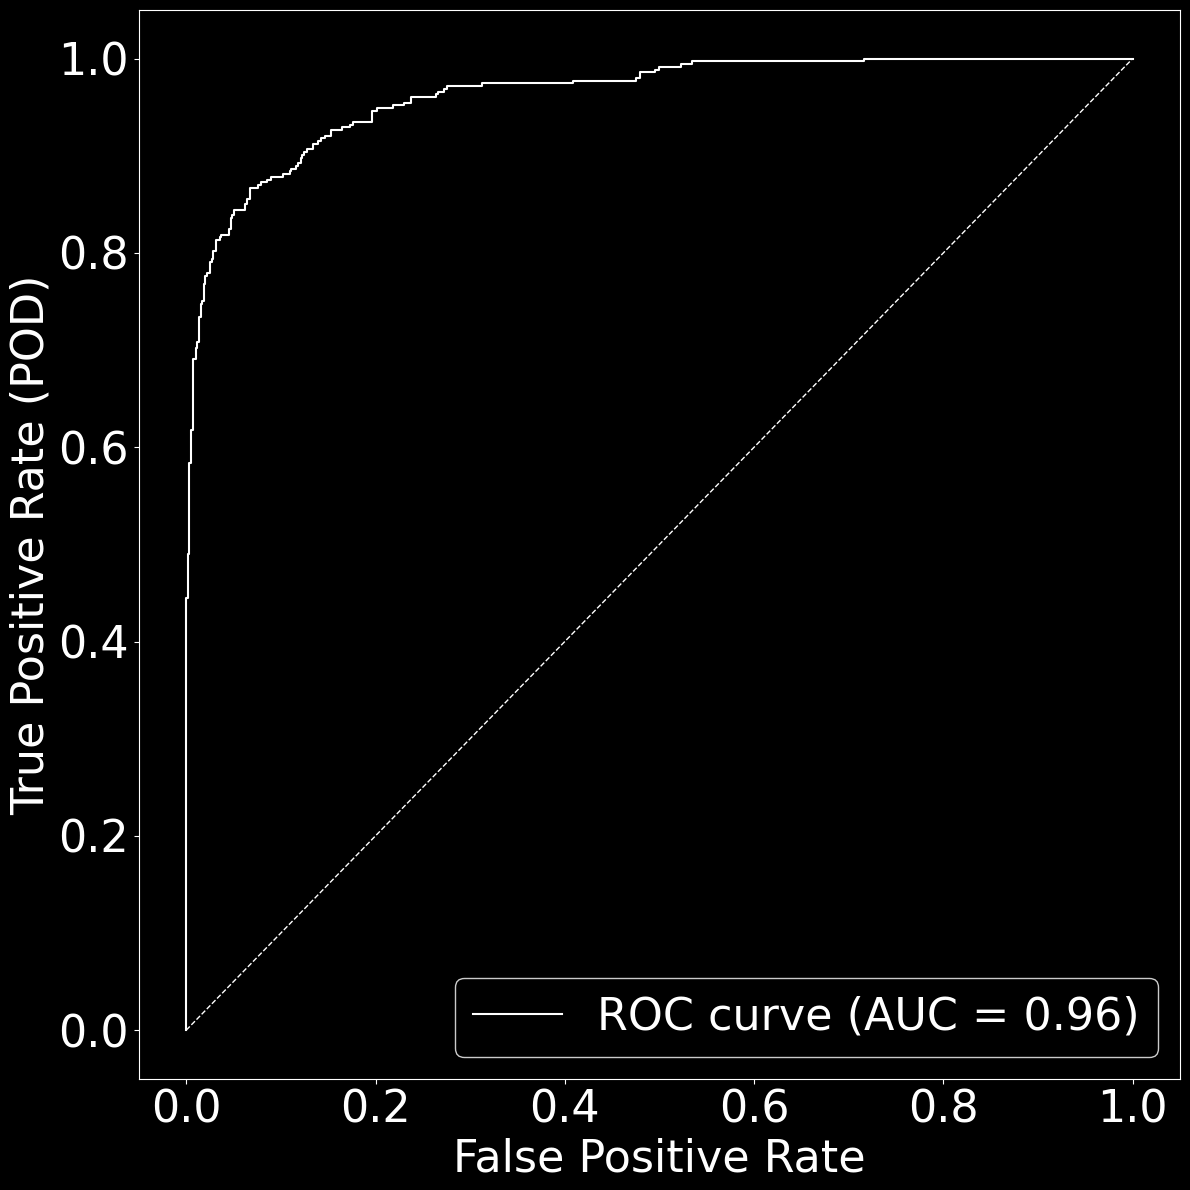

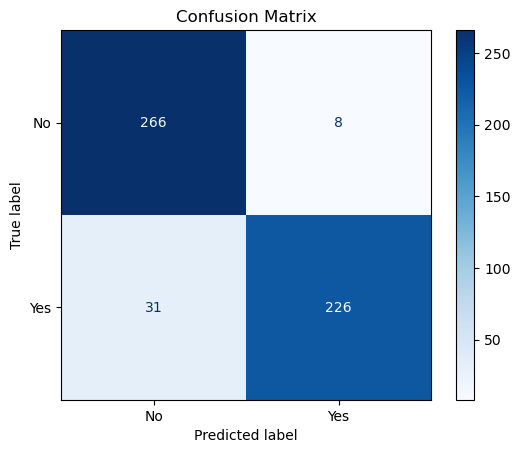

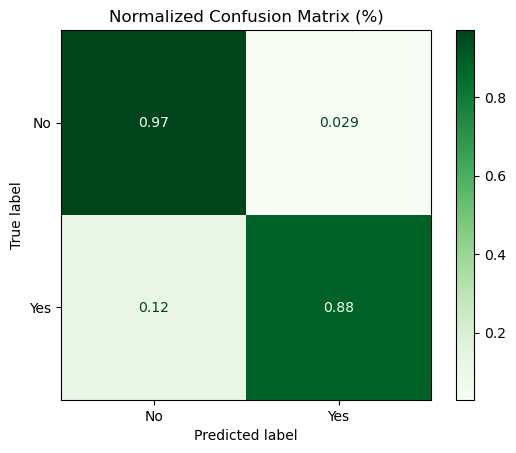

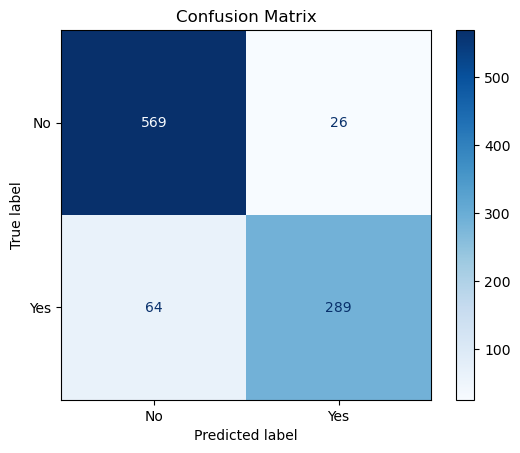

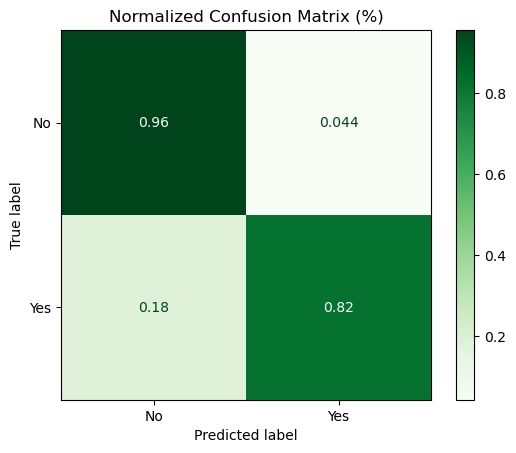

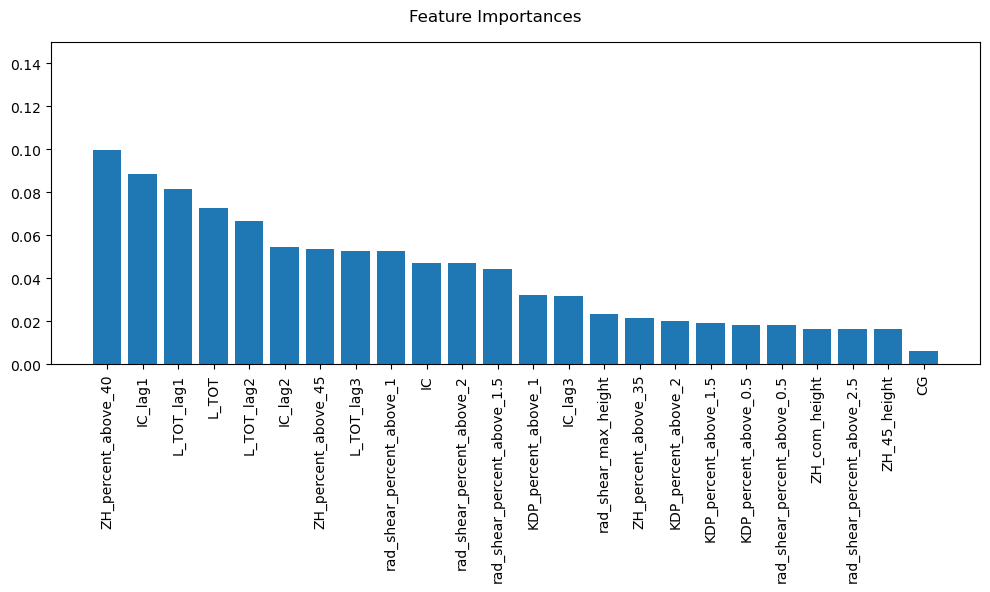

In [50]:
# Train Random Forest normal Method
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


edgecolor = 'white'
fontcolor = 'white'
backgroundcolor = 'black'
fontsize = 32


X_train = train_df_events[all_features]
y_train = train_df_events['Gust_Flag']
X_val = val_df_events[all_features]
y_val = val_df_events['Gust_Flag']
X_test = test_df_events[all_features]
y_test = test_df_events['Gust_Flag']

model = RandomForestClassifier(#class_weight='balanced', 
                               n_estimators=100, 
                               bootstrap=True,
                               #max_features="log2", 
                               max_depth=10, 
                               #max_leaf_nodes = None,
                               #max_sample = None,
                               #min_sample_split = 2
                               min_samples_leaf=1,
                               min_samples_split=2
                                )

#Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
#model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)


# 7. Evaluate
from sklearn.metrics import classification_report

y_val_pred = model.predict(X_val)
print("Validation results:")
print(classification_report(y_val, y_val_pred))


# Compute confusion matrix for validation set
cm = confusion_matrix(y_val, y_val_pred, labels=['Yes', 'No'])
a = cm[0, 0]  # True Positives (Yes/Yes)
b = cm[1, 0]  # False Positives (No/Yes)
c = cm[0, 1]  # False Negatives (Yes/No)
d = cm[1, 1]  # True Negatives (No/No)

# Calculate metrics
POD = a / (a + c) if (a + c) > 0 else 0
FAR = b / (a + b) if (a + b) > 0 else 0
CSI = a / (a + b + c) if (a + b + c) > 0 else 0

print(f"POD (Probability of Detection): {POD:.2f}")
print(f"FAR (False Alarm Ratio): {FAR:.2f}")
print(f"CSI (Critical Success Index): {CSI:.2f}")


y_test_pred = model.predict(X_test)
print("Test results:")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred, labels=['Yes', 'No'])
a = cm[0, 0]  # True Positives (Yes/Yes)
b = cm[1, 0]  # False Positives (No/Yes)
c = cm[0, 1]  # False Negatives (Yes/No)
d = cm[1, 1]  # True Negatives (No/No)

# Calculate metrics
POD = a / (a + c) if (a + c) > 0 else 0
FAR = b / (a + b) if (a + b) > 0 else 0
CSI = a / (a + b + c) if (a + b + c) > 0 else 0

print(f"POD (Probability of Detection): {POD:.2f}")
print(f"FAR (False Alarm Ratio): {FAR:.2f}")
print(f"CSI (Critical Success Index): {CSI:.2f}")


# ROC Curve
y_test_binary = (y_test == 'Yes').astype(int)
y_score = model.predict_proba(X_test)[:, list(model.classes_).index('Yes')]

fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)





import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, color=edgecolor, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=edgecolor, linestyle='--', lw=1)
plt.xlabel('False Positive Rate', color=edgecolor, fontsize=fontsize)
plt.ylabel('True Positive Rate (POD)', color=edgecolor, fontsize=fontsize)
plt.legend(loc='lower right', facecolor=backgroundcolor, edgecolor=edgecolor, labelcolor=edgecolor, fontsize=fontsize)
# Set background color
plt.gca().set_facecolor(backgroundcolor)
plt.gcf().set_facecolor(backgroundcolor)
# Set axes spines to white
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor(edgecolor)
# Set ticks and tick labels to white
ax.tick_params(colors=edgecolor, which='both', labelsize =fontsize)
plt.tight_layout()
#plt.savefig("/users/fackerma/newproject1/figures/Model/ROC_2.png", bbox_inches='tight', dpi=300 )




# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d') # Remove 'd' for percentages
plt.title("Confusion Matrix")
plt.show()
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_val,
    y_val,
    normalize='true', # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Normalized Confusion Matrix (%)")
plt.show() 



# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
# Visualize with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Remove 'd' for percentages
plt.title("Confusion Matrix")
plt.show()
disp = ConfusionMatrixDisplay.from_estimator(
    model, 
    X_test, 
    y_test,
    normalize='true',  # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Normalized Confusion Matrix (%)")
plt.show()




import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(all_features)

plt.figure(figsize=(10,6))
plt.suptitle("Feature Importances")
plt.ylim(0, 0.15)
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


#### Probabilistic training

Validation results:
              precision    recall  f1-score   support

          No       0.50      0.64      0.56       274
         Yes       0.45      0.31      0.37       257

    accuracy                           0.48       531
   macro avg       0.47      0.48      0.46       531
weighted avg       0.47      0.48      0.47       531

POD (Probability of Detection): 0.31
FAR (False Alarm Ratio): 0.55
CSI (Critical Success Index): 0.23
Test results:
              precision    recall  f1-score   support

          No       0.64      0.68      0.66       595
         Yes       0.40      0.36      0.38       353

    accuracy                           0.56       948
   macro avg       0.52      0.52      0.52       948
weighted avg       0.55      0.56      0.55       948

POD (Probability of Detection): 0.36
FAR (False Alarm Ratio): 0.60
CSI (Critical Success Index): 0.23


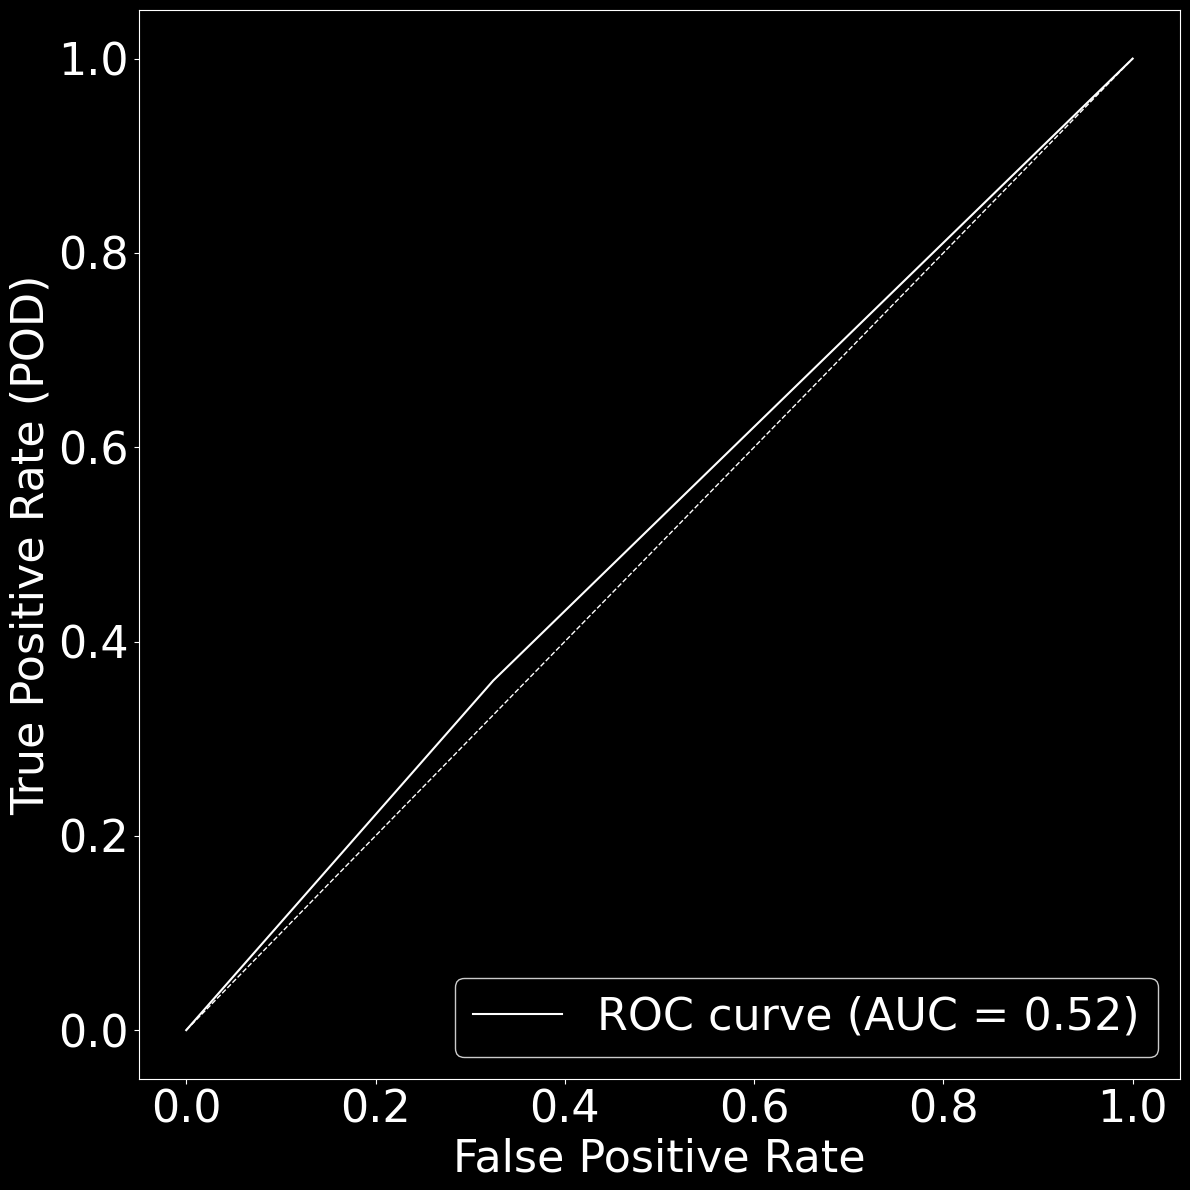

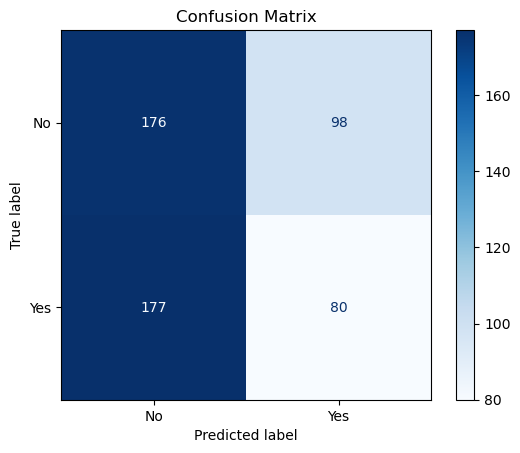

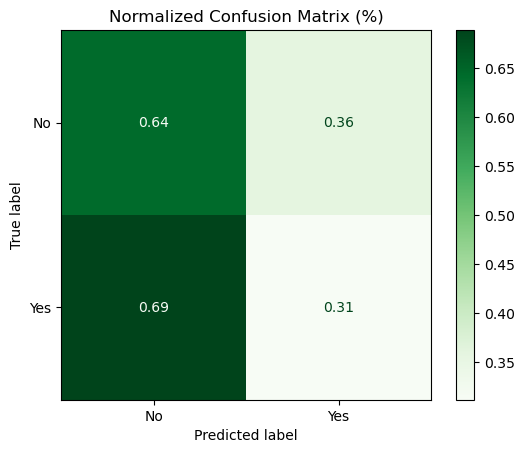

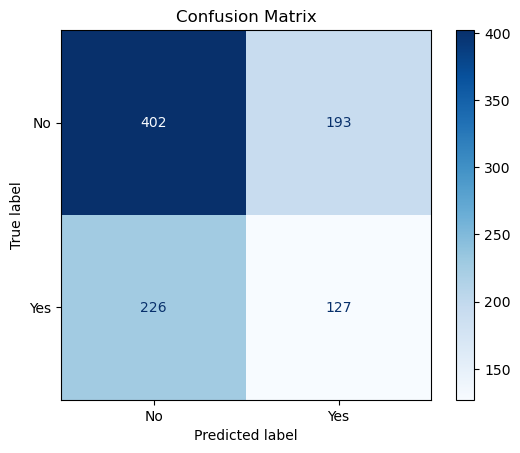

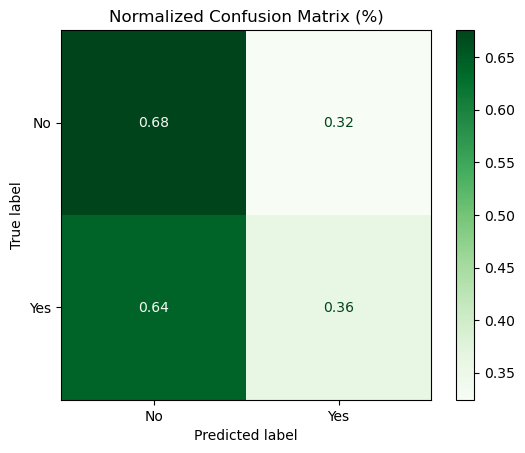

In [54]:
from sklearn.dummy import DummyClassifier


X_train = train_df_events[all_features]
y_train = train_df_events['Gust_Flag']
X_val = val_df_events[all_features]
y_val = val_df_events['Gust_Flag']
X_test = test_df_events[all_features]
y_test = test_df_events['Gust_Flag']

dummy = DummyClassifier(strategy='stratified', random_state=0)
dummy.fit(X_train, y_train)




# 7. Evaluate
from sklearn.metrics import classification_report

y_val_pred = dummy.predict(X_val)
print("Validation results:")
print(classification_report(y_val, y_val_pred))


# Compute confusion matrix for validation set
cm = confusion_matrix(y_val, y_val_pred, labels=['Yes', 'No'])
a = cm[0, 0]  # True Positives (Yes/Yes)
b = cm[1, 0]  # False Positives (No/Yes)
c = cm[0, 1]  # False Negatives (Yes/No)
d = cm[1, 1]  # True Negatives (No/No)

# Calculate metrics
POD = a / (a + c) if (a + c) > 0 else 0
FAR = b / (a + b) if (a + b) > 0 else 0
CSI = a / (a + b + c) if (a + b + c) > 0 else 0

print(f"POD (Probability of Detection): {POD:.2f}")
print(f"FAR (False Alarm Ratio): {FAR:.2f}")
print(f"CSI (Critical Success Index): {CSI:.2f}")


y_test_pred = dummy.predict(X_test)
print("Test results:")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred, labels=['Yes', 'No'])
a = cm[0, 0]  # True Positives (Yes/Yes)
b = cm[1, 0]  # False Positives (No/Yes)
c = cm[0, 1]  # False Negatives (Yes/No)
d = cm[1, 1]  # True Negatives (No/No)

# Calculate metrics
POD = a / (a + c) if (a + c) > 0 else 0
FAR = b / (a + b) if (a + b) > 0 else 0
CSI = a / (a + b + c) if (a + b + c) > 0 else 0

print(f"POD (Probability of Detection): {POD:.2f}")
print(f"FAR (False Alarm Ratio): {FAR:.2f}")
print(f"CSI (Critical Success Index): {CSI:.2f}")


# ROC Curve
y_test_binary = (y_test == 'Yes').astype(int)
y_score = dummy.predict_proba(X_test)[:, list(model.classes_).index('Yes')]

fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)





import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, color=edgecolor, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=edgecolor, linestyle='--', lw=1)
plt.xlabel('False Positive Rate', color=edgecolor, fontsize=fontsize)
plt.ylabel('True Positive Rate (POD)', color=edgecolor, fontsize=fontsize)
plt.legend(loc='lower right', facecolor=backgroundcolor, edgecolor=edgecolor, labelcolor=edgecolor, fontsize=fontsize)
# Set background color
plt.gca().set_facecolor(backgroundcolor)
plt.gcf().set_facecolor(backgroundcolor)
# Set axes spines to white
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor(edgecolor)
# Set ticks and tick labels to white
ax.tick_params(colors=edgecolor, which='both', labelsize =fontsize)
plt.tight_layout()
#plt.savefig("/users/fackerma/newproject1/figures/Model/ROC_2.png", bbox_inches='tight', dpi=300 )




# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d') # Remove 'd' for percentages
plt.title("Confusion Matrix")
plt.show()
disp = ConfusionMatrixDisplay.from_estimator(
    dummy,
    X_val,
    y_val,
    normalize='true', # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Normalized Confusion Matrix (%)")
plt.show() 



# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
# Visualize with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Remove 'd' for percentages
plt.title("Confusion Matrix")
plt.show()
disp = ConfusionMatrixDisplay.from_estimator(
    dummy, 
    X_test, 
    y_test,
    normalize='true',  # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Normalized Confusion Matrix (%)")
plt.show()





#### xgboost 

/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:43:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation results:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       274
           1       0.94      0.89      0.91       257

    accuracy                           0.92       531
   macro avg       0.92      0.92      0.92       531
weighted avg       0.92      0.92      0.92       531

Test results:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       595
           1       0.91      0.81      0.86       353

    accuracy                           0.90       948
   macro avg       0.90      0.88      0.89       948
weighted avg       0.90      0.90      0.90       948

POD (Probability of Detection): 0.81
FAR (False Alarm Ratio): 0.09
CSI (Critical Success Index): 0.75


/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


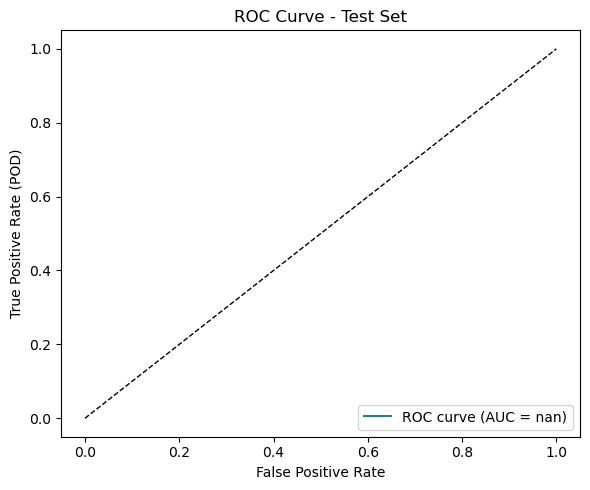

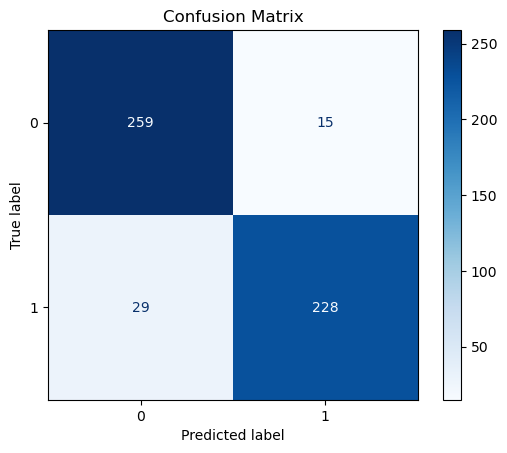

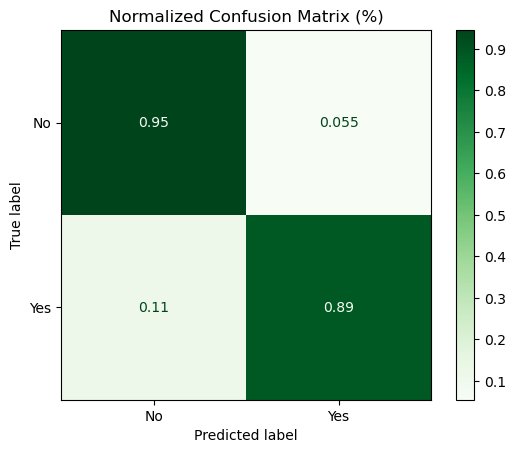

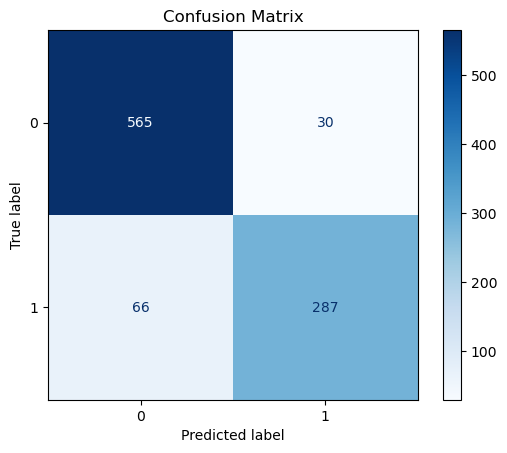

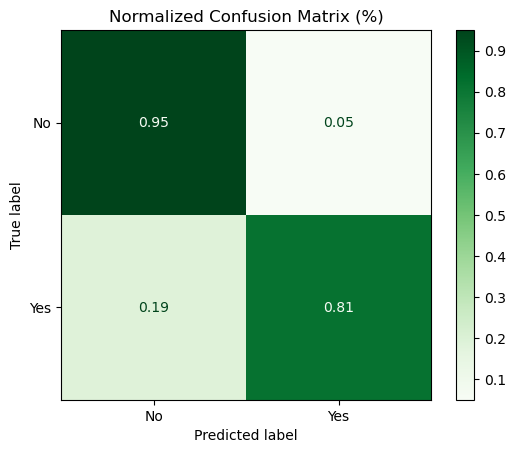

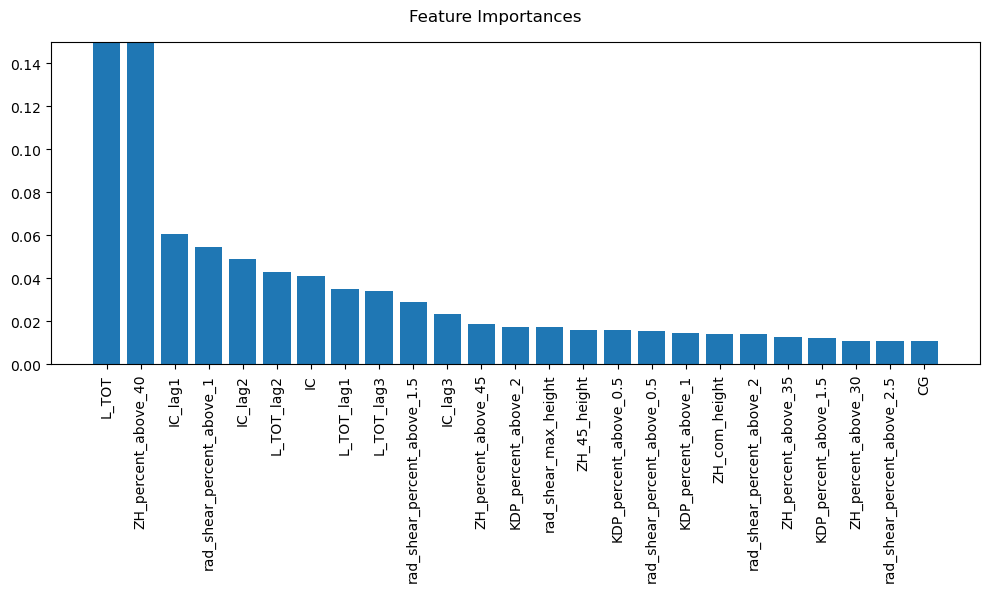

In [24]:
# xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Prepare your data as before
X_train = train_df_events[all_features]
y_train = train_df_events['Gust_Flag']
X_val = val_df_events[all_features]
y_val = val_df_events['Gust_Flag']
X_test = test_df_events[all_features]
y_test = test_df_events['Gust_Flag']



# Map 'No' to 0 and 'Yes' to 1
label_map = {'No': 0, 'Yes': 1}
y_train = train_df_events['Gust_Flag'].map(label_map)
y_val = val_df_events['Gust_Flag'].map(label_map)
y_test = test_df_events['Gust_Flag'].map(label_map)



model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)



# 7. Evaluate
from sklearn.metrics import classification_report

y_val_pred = model.predict(X_val)
print("Validation results:")
print(classification_report(y_val, y_val_pred))

y_test_pred = model.predict(X_test)
print("Test results:")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Compute confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred, labels=[1, 0])
a = cm[0, 0]  # True Positives (Yes/Yes)
b = cm[1, 0]  # False Positives (No/Yes)
c = cm[0, 1]  # False Negatives (Yes/No)
d = cm[1, 1]  # True Negatives (No/No)

# Calculate metrics
POD = a / (a + c) if (a + c) > 0 else 0
FAR = b / (a + b) if (a + b) > 0 else 0
CSI = a / (a + b + c) if (a + b + c) > 0 else 0

print(f"POD (Probability of Detection): {POD:.2f}")
print(f"FAR (False Alarm Ratio): {FAR:.2f}")
print(f"CSI (Critical Success Index): {CSI:.2f}")

# ROC Curve
y_test_binary = (y_test == 'Yes').astype(int)
y_score = model.predict_proba(X_test)[:, list(model.classes_).index(1)]

fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (POD)')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 7.1 Confusion Matrix (Add this below your existing evaluation code)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
# Visualize with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Remove 'd' for percentages
plt.title("Confusion Matrix")
plt.show()
disp = ConfusionMatrixDisplay.from_estimator(
    model, 
    X_val, 
    y_val,
    normalize='true',  # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Normalized Confusion Matrix (%)")
plt.show()


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
# Visualize with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # Remove 'd' for percentages
plt.title("Confusion Matrix")
plt.show()
disp = ConfusionMatrixDisplay.from_estimator(
    model, 
    X_test, 
    y_test,
    normalize='true',  # Normalizes row-wise (true labels)
    cmap='Greens',
    display_labels=['No', 'Yes']
)
plt.title("Normalized Confusion Matrix (%)")
plt.show()




import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(all_features)

plt.figure(figsize=(10,6))
plt.suptitle("Feature Importances")
plt.ylim(0, 0.15)
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


#### GridSearchCV

In [18]:
# Grid SearchCV for Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

KeyboardInterrupt: 

In [17]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=5)


#### Exhaustive feature selection loop

In [13]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

X_train = train_df_events[all_features]
y_train = train_df_events['Gust_Flag']
X_val = val_df_events[all_features]
y_val = val_df_events['Gust_Flag']
X_test = test_df_events[all_features]
y_test = test_df_events['Gust_Flag']

# Define a custom scoring function for CSI
def csi_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred, labels=['Yes', 'No'])
    a = cm[0, 0]  # True Positives
    b = cm[1, 0]  # False Positives
    c = cm[0, 1]  # False Negatives
    csi = a / (a + b + c) if (a + b + c) > 0 else 0
    return csi

# Set the range for number of features to consider
min_features = 2
max_features = 2

# Initialize the Random Forest model
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

# Run exhaustive feature selection
efs = EFS(
    rf,
    min_features=min_features,
    max_features=max_features,
    scoring=csi_scorer,
    print_progress=True,
    cv=2  # Use cv=2 for speed; increase for more robust results
)

efs = efs.fit(X_train, y_train)

# Get the best feature subset(s) and their CSI scores
best_idx = np.argmax(efs.get_metric_dict().values())
best_features = list(efs.get_metric_dict().values())[best_idx]['feature_names']
best_score = list(efs.get_metric_dict().values())[best_idx]['avg_score']

print("Best feature subset:", best_features)
print("Best average CSI:", best_score)

# To see all combinations ranked by CSI:
results = sorted(
    [(v['feature_names'], v['avg_score']) for v in efs.get_metric_dict().values()],
    key=lambda x: x[1], reverse=True
)
for features, score in results:
    print(f"Features: {features}, CSI: {score:.3f}")

Features: 300/300

Best feature subset: ('dBZmax', 'velocity')
Best average CSI: 0.37363618690463496
Features: ('area45', 'L_TOT'), CSI: 0.549
Features: ('area45', 'IC'), CSI: 0.537
Features: ('rad_shear_percent_above_1', 'ZH_percent_above_40'), CSI: 0.537
Features: ('IC', 'KDP_percent_above_2'), CSI: 0.535
Features: ('CG', 'L_TOT'), CSI: 0.533
Features: ('area45', 'KDP_percent_above_1'), CSI: 0.532
Features: ('area45', 'KDP_percent_above_1.5'), CSI: 0.528
Features: ('L_TOT', 'KDP_percent_above_2'), CSI: 0.527
Features: ('L_TOT', 'KDP_percent_above_1'), CSI: 0.525
Features: ('CG', 'IC'), CSI: 0.524
Features: ('L_TOT', 'ZH_45_height'), CSI: 0.524
Features: ('L_TOT', 'Z_top_smoothness'), CSI: 0.523
Features: ('ZH_percent_above_40', 'ZH_percent_above_35'), CSI: 0.522
Features: ('L_TOT', 'ZH_percent_above_45'), CSI: 0.520
Features: ('rad_shear_percent_above_1.5', 'ZH_percent_above_40'), CSI: 0.520
Features: ('IC', 'rad_shear_percent_above_2.5'), CSI: 0.519
Features: ('L_TOT', 'KDP_percent_above_1.5'), CSI: 0

## Investigate a validated ID

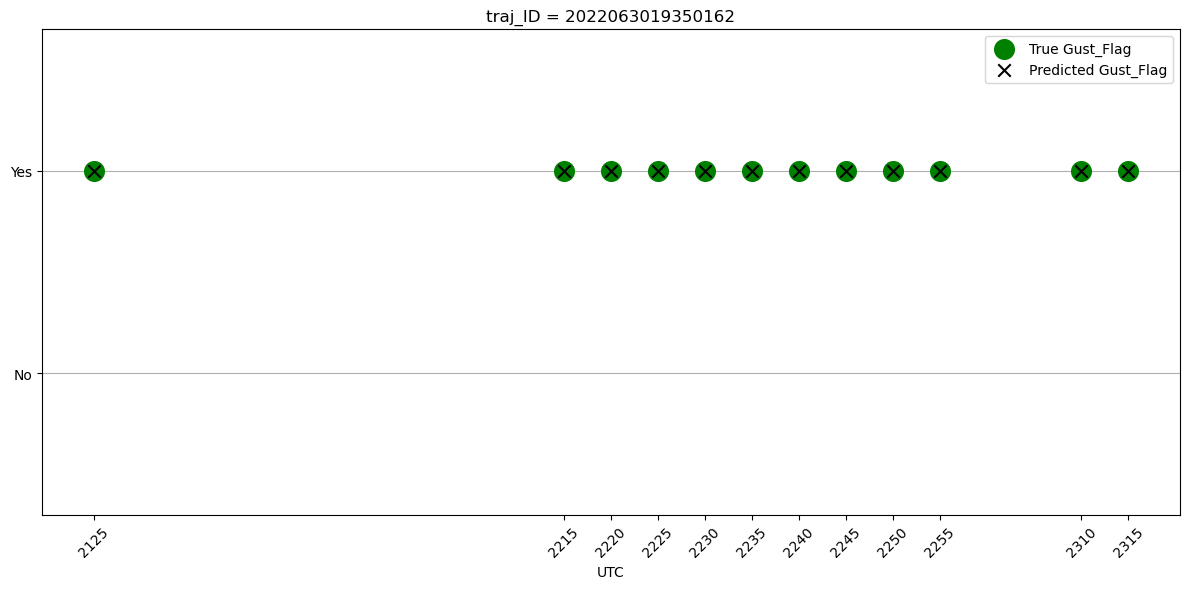

In [101]:
# Plot for a single ID
import matplotlib.pyplot as plt
import pandas as pd


manual_traj_ids = set(['2019061509450011.0','2021071217550028.0','2021071221500035.0','2021071305200023.0','2022063019350162','2023082417300207'])


specified_traj_id = '2022063019350162'


#model = RandomForestClassifier(#class_weight='balanced', 
                               #n_estimators=100, 
                               #bootstrap=True,
                               #max_features="log2", 
                               #max_depth=10, 
                               #max_leaf_nodes = None,
                               #max_sample = None,
                               #min_sample_split = 2
                               #min_samples_leaf=1,
                               #min_samples_split=2
                                #)
#model.fit(X_train, y_train)


traj_data = val_df_events[val_df_events['traj_ID'] == specified_traj_id].copy()
traj_data['Gust_Flag_pred'] = model.predict(traj_data[all_features])
traj_data['Gust_Flag_num'] = traj_data['Gust_Flag'].map({'Yes': 1, 'No': 0})
traj_data['Gust_Flag_pred_num'] = traj_data['Gust_Flag_pred'].map({'Yes': 1, 'No': 0})

# Ensure yyyymmddHHMM is string for slicing
traj_data['yyyymmddHHMM'] = traj_data['yyyymmddHHMM'].astype(str)
# Convert to datetime for proportional spacing
traj_data['timestamp'] = pd.to_datetime(traj_data['yyyymmddHHMM'], format='%Y%m%d%H%M')

plt.figure(figsize=(12, 6))




# Big green dots for true Gust_Flag
plt.scatter(
    traj_data['timestamp'],
    traj_data['Gust_Flag_num'],
    s=200,                # big size
    color='green',
    label='True Gust_Flag',
    zorder=3
)

# Smaller black x for predicted Gust_Flag
plt.scatter(
    traj_data['timestamp'],
    traj_data['Gust_Flag_pred_num'],
    s=80,                 # smaller size
    color='black',
    marker='x',
    label='Predicted Gust_Flag',
    zorder=4
)

plt.xlabel('UTC')
plt.ylim(-0.7, 1.7)
plt.yticks([0, 1], ['No', 'Yes'])

# Custom x-axis tick labels: show only last 4 digits (HHMM)
tick_locs = traj_data['timestamp']
tick_labels = traj_data['yyyymmddHHMM'].str[-4:]
plt.xticks(tick_locs, tick_labels, rotation=45)

plt.title(f'traj_ID = {specified_traj_id}')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
#plt.savefig(f'/users/fackerma/newproject1/figures/Model/{specified_traj_id}_1.png', bbox_inches='tight', dpi=300)



In [99]:
traj_data['timestamp']

8054   2022-06-30 21:25:00
8069   2022-06-30 22:15:00
8072   2022-06-30 22:20:00
8077   2022-06-30 22:25:00
8078   2022-06-30 22:30:00
8082   2022-06-30 22:35:00
8086   2022-06-30 22:40:00
8089   2022-06-30 22:45:00
8092   2022-06-30 22:50:00
8094   2022-06-30 22:55:00
8103   2022-06-30 23:10:00
8105   2022-06-30 23:15:00
Name: timestamp, dtype: datetime64[ns]

In [79]:
specified_traj_id = '2021071217550028.0'

val_df_events[val_df_events['traj_ID'] == specified_traj_id]

,geometry,Age,CS Marker,STA Marker,ESWD Marker,STA Speed,Gust_Flag,time,traj_ID,yyyymmddHHMM,...,rad_shear_max_height,velocity,Z_top_smoothness,CoreAspect_ratio,IC_lag1,IC_lag2,IC_lag3,L_TOT_lag1,L_TOT_lag2,L_TOT_lag3
787,"POLYGON ((7.8948 47.3055, 7.8948 47.2965, 7.86...",155.0,0,1,0,37.6,Yes,1626121800000000,2021071217550028.0,202107122030,...,46.0,54.357937,14.0,0.150502,61.847787,117.533706,143.051761,63.847787,117.533706,145.051761
789,"POLYGON ((7.9481 47.3412, 7.9478 47.3143, 7.93...",160.0,0,1,0,37.6,Yes,1626122100000000,2021071217550028.0,202107122035,...,9.0,52.159264,9.0,0.151316,103.000000,61.847787,117.533706,108.000000,63.847787,117.533706
791,"POLYGON ((7.9482 47.3502, 7.9481 47.3412, 7.93...",165.0,0,1,0,37.6,Yes,1626122400000000,2021071217550028.0,202107122040,...,19.0,51.364472,13.0,0.152778,1.000000,103.000000,61.847787,4.000000,108.000000,63.847787


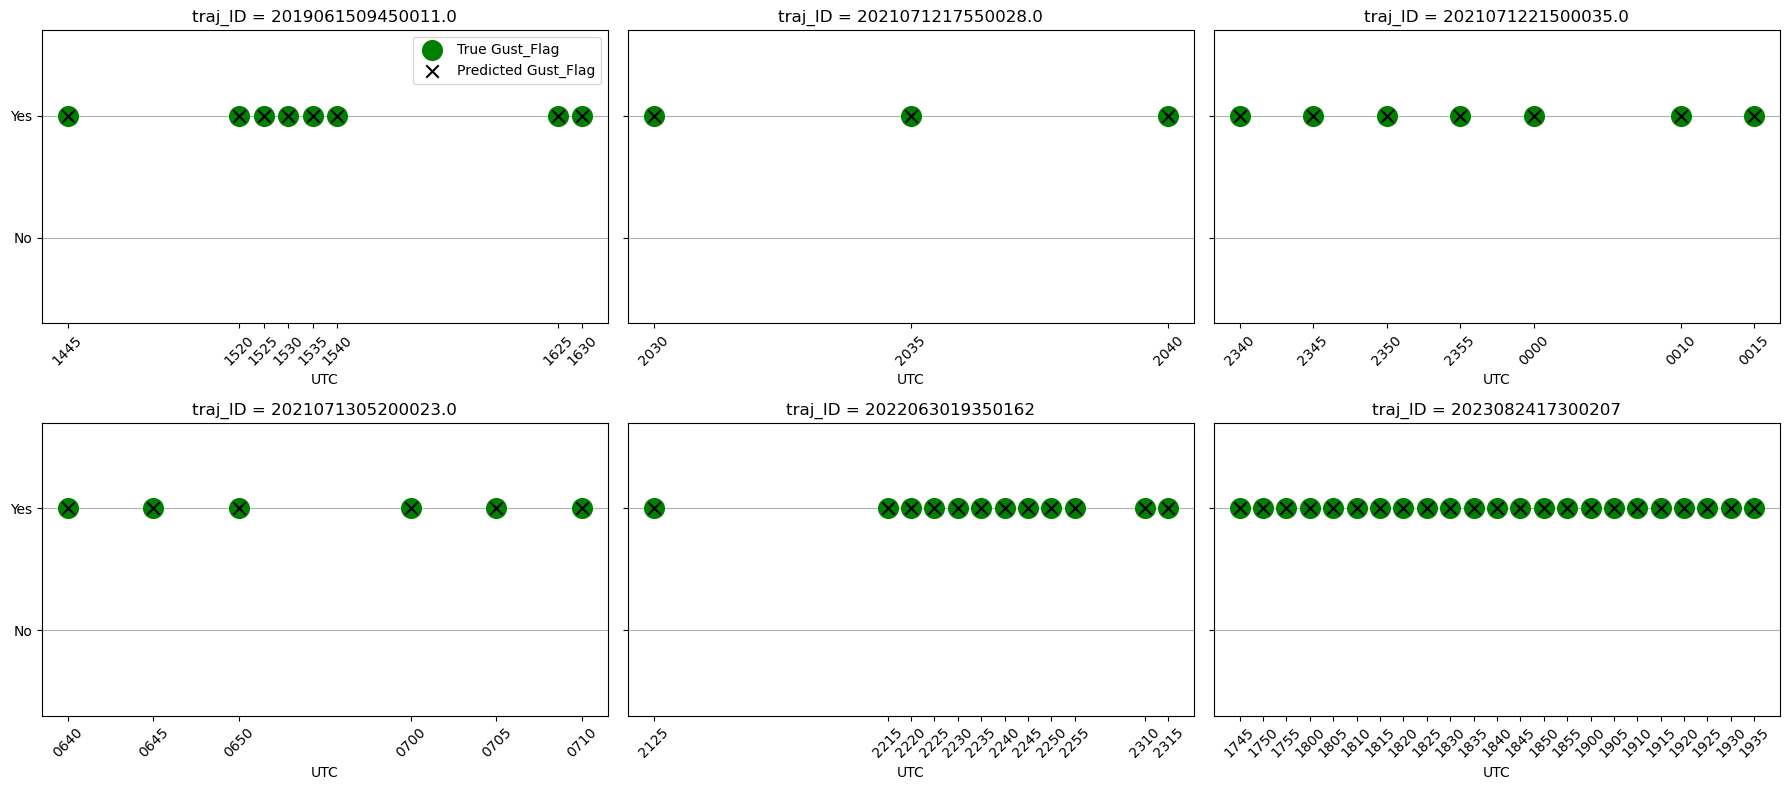

In [82]:
# Plot for a all IDs
import matplotlib.pyplot as plt
import pandas as pd

manual_traj_ids = [
    '2019061509450011.0',
    '2021071217550028.0',
    '2021071221500035.0',
    '2021071305200023.0',
    '2022063019350162',
    '2023082417300207'
]

model = RandomForestClassifier(#class_weight='balanced', 
                               n_estimators=100, 
                               bootstrap=True,
                               #max_features="log2", 
                               max_depth=10, 
                               #max_leaf_nodes = None,
                               #max_sample = None,
                               #min_sample_split = 2
                               min_samples_leaf=1,
                               min_samples_split=2
                                )
model.fit(X_train, y_train)

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
axes = axes.flatten()

for idx, specified_traj_id in enumerate(manual_traj_ids):
    ax = axes[idx]
    traj_data = val_df_events[val_df_events['traj_ID'] == specified_traj_id].copy()
    if traj_data.empty:
        ax.set_title(f'{specified_traj_id}\n(no data)')
        ax.axis('off')
        continue

    traj_data['Gust_Flag_pred'] = model.predict(traj_data[all_features])
    traj_data['Gust_Flag_num'] = traj_data['Gust_Flag'].map({'Yes': 1, 'No': 0})
    traj_data['Gust_Flag_pred_num'] = traj_data['Gust_Flag_pred'].map({'Yes': 1, 'No': 0})

    traj_data['yyyymmddHHMM'] = traj_data['yyyymmddHHMM'].astype(str)
    traj_data['timestamp'] = pd.to_datetime(traj_data['yyyymmddHHMM'], format='%Y%m%d%H%M')

    # True Gust_Flag: big green dot
    ax.scatter(
        traj_data['timestamp'],
        traj_data['Gust_Flag_num'],
        s=200,
        color='green',
        label='True Gust_Flag',
        zorder=3
    )

    # Predicted Gust_Flag: smaller black x
    ax.scatter(
        traj_data['timestamp'],
        traj_data['Gust_Flag_pred_num'],
        s=80,
        color='black',
        marker='x',
        label='Predicted Gust_Flag',
        zorder=4
    )

    ax.set_ylim(-0.7, 1.7)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel('UTC')
    ax.set_title(f'traj_ID = {specified_traj_id}')

    # Custom x-axis tick labels: only last 4 digits (HHMM)
    tick_locs = traj_data['timestamp']
    tick_labels = traj_data['yyyymmddHHMM'].str[-4:]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45)

    ax.grid(True, axis='y')
    if idx == 0:
        ax.legend()

# Hide any unused subplots (if less than 6 IDs)
for j in range(len(manual_traj_ids), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
#plt.savefig(f'/users/fackerma/newproject1/figures/Model/Try_optimized.png', bbox_inches='tight', dpi=300)



/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted with

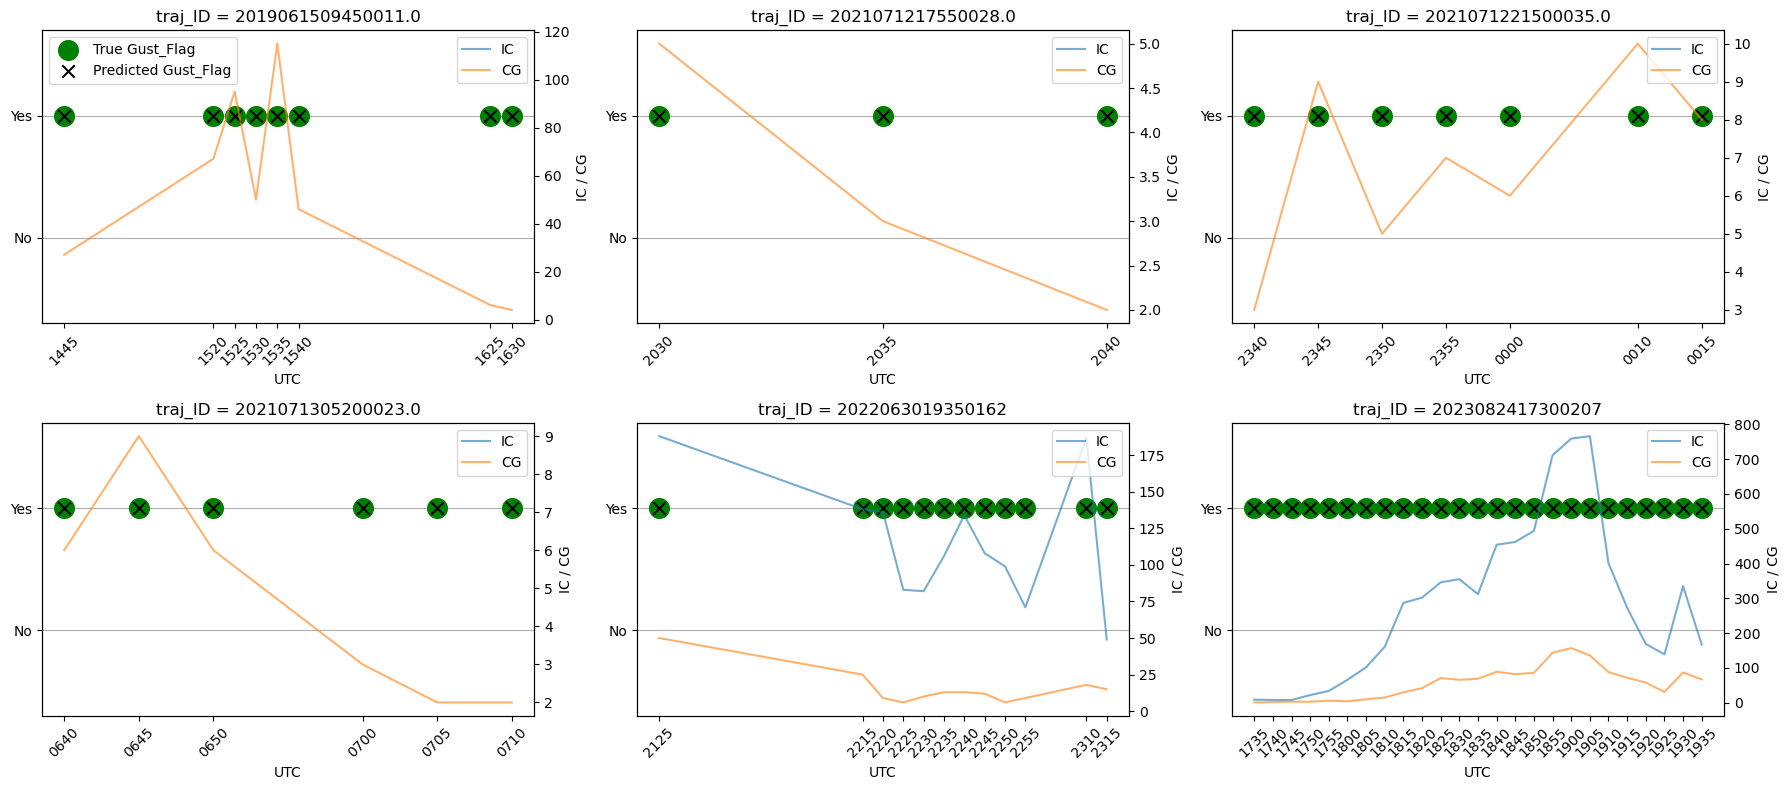

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=False)
axes = axes.flatten()

for idx, specified_traj_id in enumerate(manual_traj_ids):
    ax = axes[idx]
    traj_data = val_df_events[val_df_events['traj_ID'] == specified_traj_id].copy()
    if traj_data.empty:
        ax.set_title(f'{specified_traj_id}\n(no data)')
        ax.axis('off')
        continue

    # Ensure timestamp is datetime
    traj_data['timestamp'] = pd.to_datetime(traj_data['yyyymmddHHMM'].astype(str), format='%Y%m%d%H%M')

    # --- Plot IC and GC for ALL timesteps on secondary y-axis ---
    ax2 = ax.twinx()
    ax2.plot(traj_data['timestamp'], traj_data['IC'], label='IC', color='tab:blue', alpha=0.6)
    ax2.plot(traj_data['timestamp'], traj_data['CG'], label='CG', color='tab:orange', alpha=0.6)
    ax2.set_ylabel('IC / CG')
    ax2.legend(loc='upper right')

    # --- Overlay Gust_Flag and predictions for timesteps where Gust_Flag is Yes/No ---
    mask = traj_data['Gust_Flag'].isin(['Yes', 'No'])
    if mask.any():
        traj_data.loc[mask, 'Gust_Flag_pred'] = model.predict(traj_data.loc[mask, all_features])
        traj_data.loc[mask, 'Gust_Flag_num'] = traj_data.loc[mask, 'Gust_Flag'].map({'Yes': 1, 'No': 0})
        traj_data.loc[mask, 'Gust_Flag_pred_num'] = traj_data.loc[mask, 'Gust_Flag_pred'].map({'Yes': 1, 'No': 0})

        # True Gust_Flag: big green dot
        ax.scatter(
            traj_data.loc[mask, 'timestamp'],
            traj_data.loc[mask, 'Gust_Flag_num'],
            s=200,
            color='green',
            label='True Gust_Flag',
            zorder=3
        )

        # Predicted Gust_Flag: smaller black x
        ax.scatter(
            traj_data.loc[mask, 'timestamp'],
            traj_data.loc[mask, 'Gust_Flag_pred_num'],
            s=80,
            color='black',
            marker='x',
            label='Predicted Gust_Flag',
            zorder=4
        )

    ax.set_ylim(-0.7, 1.7)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel('UTC')
    ax.set_title(f'traj_ID = {specified_traj_id}')
    ax.grid(True, axis='y')

    # Custom x-axis tick labels: only last 4 digits (HHMM)
    tick_locs = traj_data['timestamp']
    tick_labels = traj_data['yyyymmddHHMM'].str[-4:]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45)

    if idx == 0:
        ax.legend(loc='upper left')

# Hide unused subplots
for j in range(len(manual_traj_ids), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


#### Find some negative Cases

In [ ]:
# Subset where 'Gust_Flag' == 'No'
subset = val_df_events[val_df_events['Gust_Flag'] == 'No']

subset_sorted = subset.sort_values(by='RANKr', ascending=False)
print(subset_sorted.head(10))




                                                geometry    Age  CS Marker  \
24208  POLYGON ((7.6715 47.6389, 7.6582 47.63, 7.6581...   60.0          0   
10920  POLYGON ((7.0116 46.9638, 7.0118 46.9458, 6.97...  105.0          0   
14158  POLYGON ((7.524 46.9645, 7.524 46.9466, 7.5109...  105.0          0   
13113  POLYGON ((8.8155 46.0836, 8.8023 46.0748, 8.80...   70.0          0   
23020  POLYGON ((8.2889 47.1413, 8.2756 47.1324, 8.24...   20.0          0   
7581   POLYGON ((7.0005 46.7119, 6.9875 46.7028, 6.98...   30.0          0   
24196  POLYGON ((7.6448 47.612, 7.6447 47.603, 7.6314...   55.0          0   
10761  POLYGON ((6.935 46.7296, 6.9353 46.6936, 6.922...   20.0          0   
23014  POLYGON ((8.157 47.1332, 8.1568 47.1152, 8.169...   15.0          0   
27092  POLYGON ((7.168 47.2161, 7.1681 47.2071, 7.154...   15.0          0   

       STA Marker  ESWD Marker  STA Speed Gust_Flag              time  \
24208           0            0        NaN        No  168944880000000

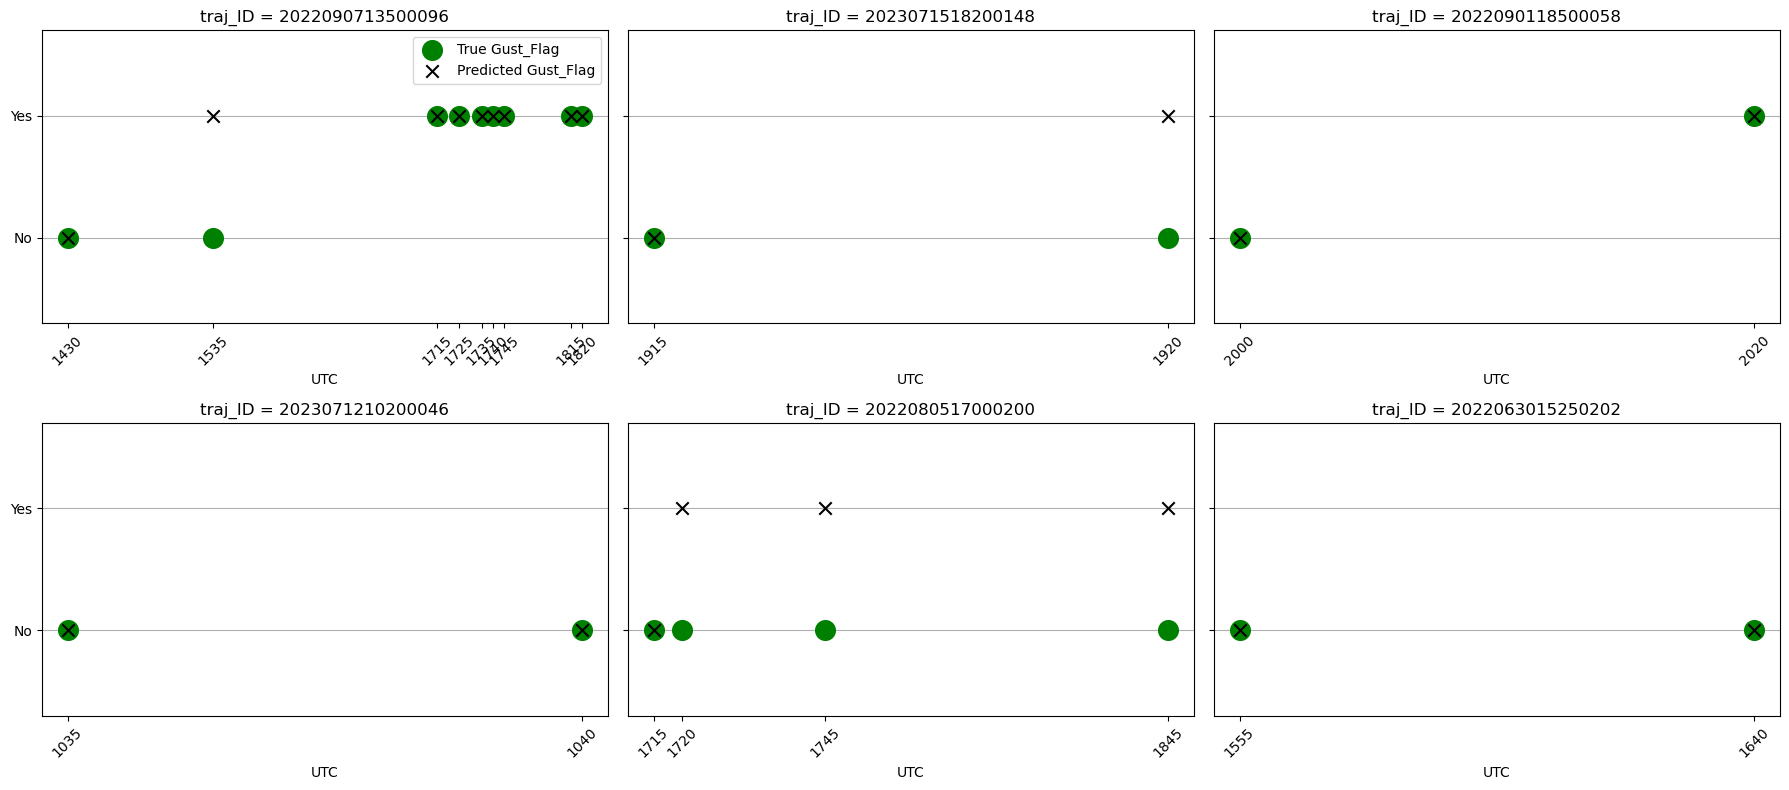

In [ ]:
# Plot for a all IDs
import matplotlib.pyplot as plt
import pandas as pd

manual_traj_ids_negative = set(['2023071518200148','2022080517000200','2022090713500096','2022090118500058','2023071210200046', '2022063015250202'])


model = RandomForestClassifier(#class_weight='balanced', 
                               n_estimators=100, 
                               bootstrap=True,
                               #max_features="log2", 
                               max_depth=10, 
                               #max_leaf_nodes = None,
                               #max_sample = None,
                               #min_sample_split = 2
                               min_samples_leaf=1,
                               min_samples_split=2
                                )
model.fit(X_train, y_train)

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
axes = axes.flatten()

for idx, specified_traj_id in enumerate(manual_traj_ids_negative):
    ax = axes[idx]
    traj_data = val_df_events[val_df_events['traj_ID'] == specified_traj_id].copy()
    if traj_data.empty:
        ax.set_title(f'{specified_traj_id}\n(no data)')
        ax.axis('off')
        continue

    traj_data['Gust_Flag_pred'] = model.predict(traj_data[all_features])
    traj_data['Gust_Flag_num'] = traj_data['Gust_Flag'].map({'Yes': 1, 'No': 0})
    traj_data['Gust_Flag_pred_num'] = traj_data['Gust_Flag_pred'].map({'Yes': 1, 'No': 0})

    traj_data['yyyymmddHHMM'] = traj_data['yyyymmddHHMM'].astype(str)
    traj_data['timestamp'] = pd.to_datetime(traj_data['yyyymmddHHMM'], format='%Y%m%d%H%M')

    # True Gust_Flag: big green dot
    ax.scatter(
        traj_data['timestamp'],
        traj_data['Gust_Flag_num'],
        s=200,
        color='green',
        label='True Gust_Flag',
        zorder=3
    )

    # Predicted Gust_Flag: smaller black x
    ax.scatter(
        traj_data['timestamp'],
        traj_data['Gust_Flag_pred_num'],
        s=80,
        color='black',
        marker='x',
        label='Predicted Gust_Flag',
        zorder=4
    )

    ax.set_ylim(-0.7, 1.7)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel('UTC')
    ax.set_title(f'traj_ID = {specified_traj_id}')

    # Custom x-axis tick labels: only last 4 digits (HHMM)
    tick_locs = traj_data['timestamp']
    tick_labels = traj_data['yyyymmddHHMM'].str[-4:]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45)

    ax.grid(True, axis='y')
    if idx == 0:
        ax.legend()

# Hide any unused subplots (if less than 6 IDs)
for j in range(len(manual_traj_ids), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
#plt.savefig(f'/users/fackerma/newproject1/figures/Model/Try_optimized_neg.png', bbox_inches='tight', dpi=300)



## SHAP Tree Interpreter

In [90]:
# Create the explainer

import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)


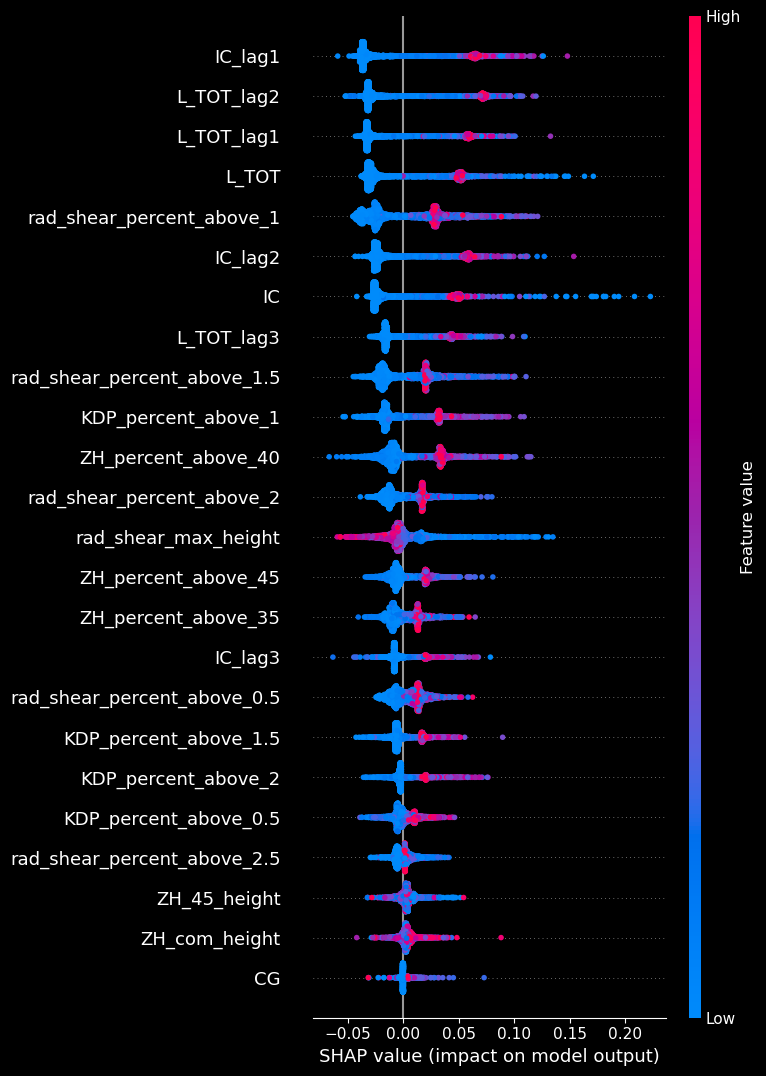

In [ ]:
import matplotlib.pyplot as plt
import shap

edgecolor = 'white'

plt.rcParams.update({
    'font.size': 18,           # Default text size
    'axes.titlesize': 18,      # Axes title
    'axes.labelsize': 18,      # X and Y labels
    'xtick.labelsize': 18,     # X tick labels
    'ytick.labelsize': 18,     # Y tick labels
    'legend.fontsize': 18,     # Legend
    'figure.titlesize': 18     # Figure title
})

plt.style.use('dark_background')

plt.figure(figsize=(24, 20))
shap.summary_plot(shap_values[:,:,1], X_train, plot_type="dot", show=False, max_display=200)

ax = plt.gca()
ax.set_xlabel(ax.get_xlabel(), color=edgecolor)  # Set x-axis label color to white
ax.set_ylabel(ax.get_ylabel(), color=edgecolor)  # Set y-axis label color to white
ax.tick_params(axis='x', colors=edgecolor)       # Set x-tick color to white
ax.tick_params(axis='y', colors=edgecolor)       # Set y-tick color to white


plt.tight_layout()
#plt.savefig("/users/fackerma/newproject1/figures/Model/SHAP_Summary_2.png", bbox_inches='tight', dpi=200)


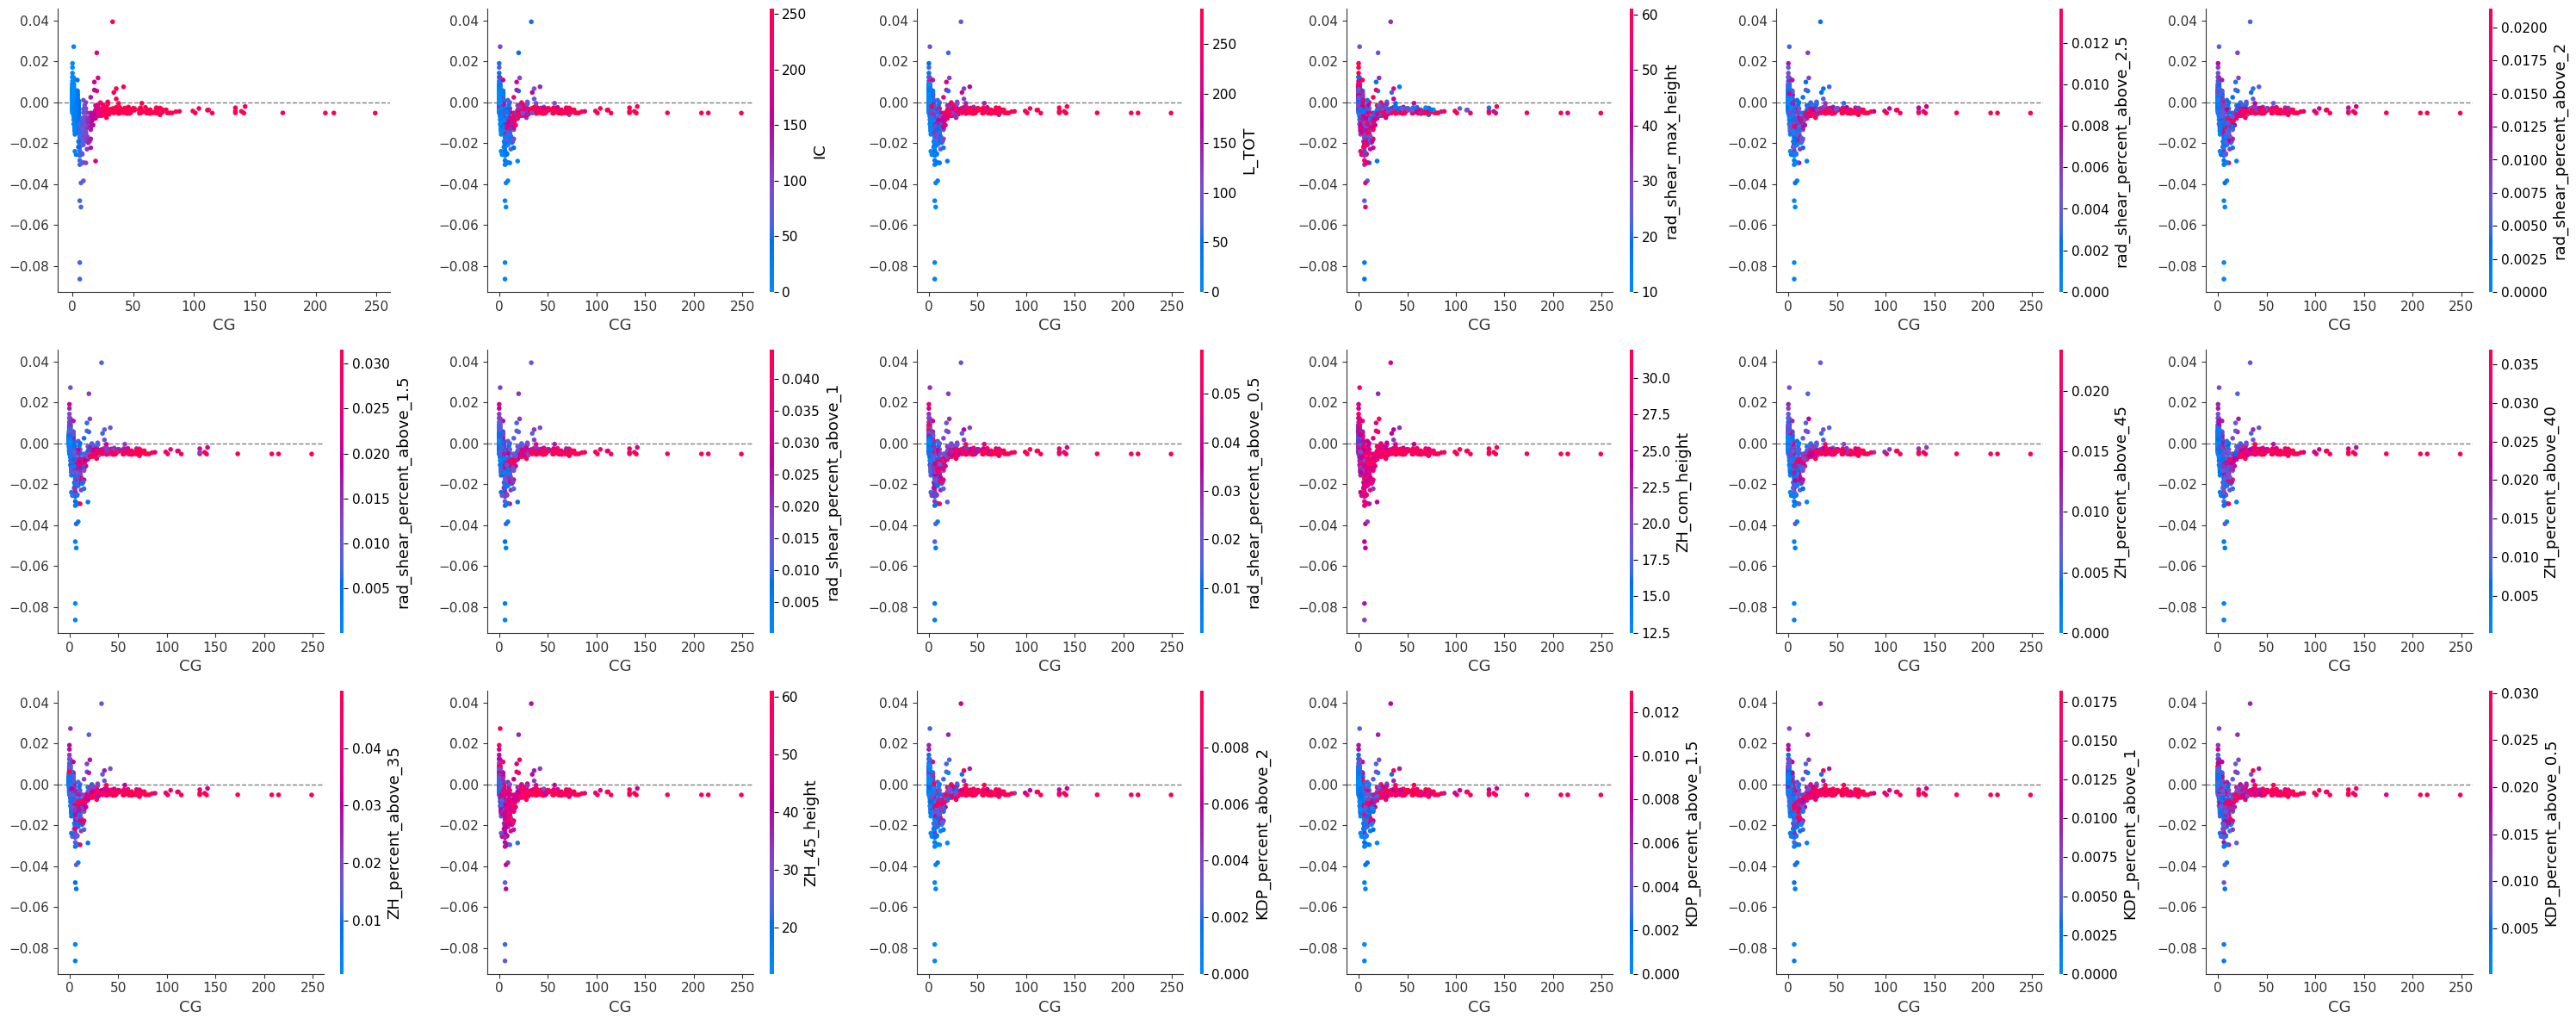

In [44]:
import matplotlib.pyplot as plt
import math

# List of features you want to plot
features = ['rad_shear_percent_above_2', 'rad_shear_percent_above_1.5', 'rad_shear_percent_above_1', 'rad_shear_max',
            'ZH_percent_above_40', 'ZH_percent_above_35', 'ZH_percent_above_30', 'dBZmax',
            'KDP_percent_above_1.5', 'KDP_percent_above_1', 'KDP_percent_above_0.5', 'KDP_95th_percentile',
            'area45','velocity','area','IC',
            'area57','RANKr', 'L_TOT','L_TOT_delta1'
            ]  # Example with 7 features

features = features_no_lags

interaction_var = 'CG'
plots_per_row = 6
n_features = len(features)
nrows = math.ceil(n_features / plots_per_row)
ncols = min(plots_per_row, n_features)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))

# axes could be 1D or 2D depending on nrows/ncols, flatten for easy iteration
axes = axes.flatten() if n_features > 1 else [axes]

for i, feature in enumerate(features):
    shap.dependence_plot(
        interaction_var,
        shap_values[:,:,:1],  # Your SHAP values for class 1
        X_train,
        interaction_index=feature,
        ax=axes[i],
        show=False
    )
    axes[i].axhline(y=0, color='grey', linestyle='--', linewidth=1, zorder=0)

# Hide any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

for ax in axes:
    ax.set_ylabel('') 

plt.tight_layout()
plt.show()


In [97]:
# Investigate 
# Train Random Forest normal Method
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

X_train = train_df_events[all_features]
y_train = train_df_events['Gust_Flag']
X_val = val_df_events[all_features]
y_val = val_df_events['Gust_Flag']
X_test = test_df_events[all_features]
y_test = test_df_events['Gust_Flag']

model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

# 7. Evaluate
from sklearn.metrics import classification_report

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)



val_df_events_with_pred = val_df_events.copy()
val_df_events_with_pred['Gust_Flag_Pred'] = y_val_pred

test_df_events_with_pred = test_df_events.copy()
test_df_events_with_pred['Gust_Flag_Pred'] = y_test_pred


# True Positives: Actual = Yes, Predicted = Yes
tp_val = val_df_events_with_pred[
    (val_df_events_with_pred['Gust_Flag'] == 'Yes') & 
    (val_df_events_with_pred['Gust_Flag_Pred'] == 'Yes')
]

# True Negatives: Actual = No, Predicted = No
tn_val = val_df_events_with_pred[
    (val_df_events_with_pred['Gust_Flag'] == 'No') & 
    (val_df_events_with_pred['Gust_Flag_Pred'] == 'No')
]

# False Positives: Actual = No, Predicted = Yes
fp_val = val_df_events_with_pred[
    (val_df_events_with_pred['Gust_Flag'] == 'No') & 
    (val_df_events_with_pred['Gust_Flag_Pred'] == 'Yes')
]

# False Negatives: Actual = Yes, Predicted = No
fn_val = val_df_events_with_pred[
    (val_df_events_with_pred['Gust_Flag'] == 'Yes') & 
    (val_df_events_with_pred['Gust_Flag_Pred'] == 'No')
]

# True Positives: Actual = Yes, Predicted = Yes
tp_test = test_df_events_with_pred[
    (test_df_events_with_pred['Gust_Flag'] == 'Yes') & 
    (test_df_events_with_pred['Gust_Flag_Pred'] == 'Yes')
]

# True Negatives: Actual = No, Predicted = No
tn_test = test_df_events_with_pred[
    (test_df_events_with_pred['Gust_Flag'] == 'No') & 
    (test_df_events_with_pred['Gust_Flag_Pred'] == 'No')
]

# False Positives: Actual = No, Predicted = Yes
fp_test = test_df_events_with_pred[
    (test_df_events_with_pred['Gust_Flag'] == 'No') & 
    (test_df_events_with_pred['Gust_Flag_Pred'] == 'Yes')
]

# False Negatives: Actual = Yes, Predicted = No
fn_test = test_df_events_with_pred[
    (test_df_events_with_pred['Gust_Flag'] == 'Yes') & 
    (test_df_events_with_pred['Gust_Flag_Pred'] == 'No')
]

tp_val_idx = tp_val.index.tolist()
tn_val_idx = tn_val.index.tolist()
fp_val_idx = fp_val.index.tolist()
fn_val_idx = fn_val.index.tolist()

tp_test_idx = tp_test.index.tolist()
tn_test_idx = tn_test.index.tolist()
fp_test_idx = fp_test.index.tolist()
fn_test_idx = fn_test.index.tolist()


In [136]:
import shap

#data = 'fn'
#position = '6'

#num = int({data}_val_idx[position])

data = 'fn'
position = '6'

var_name = f"{data}_val_idx"
num = int(globals()[var_name][int(position)])

# Calculate Shap values
choosen_instance = X_val.loc[[num]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[:, :, 1], choosen_instance, plot_cmap=["#ca0020", "#92c5de"])

plt.savefig(f'/users/fackerma/newproject1/figures/Model/{data}_{position}.png')


<Figure size 640x480 with 0 Axes>

In [137]:
import shap
import matplotlib.pyplot as plt

# Your variable selection logic
data = 'fn'
position = '6'
var_name = f"{data}_val_idx"
num = int(globals()[var_name][int(position)])

# Calculate SHAP values
choosen_instance = X_val.loc[[num]]
shap_values = explainer.shap_values(choosen_instance)

# Generate and save the force plot using matplotlib
shap.force_plot(
    explainer.expected_value[1],
    shap_values[:, :, 1],
    choosen_instance,
    plot_cmap=["#ca0020", "#92c5de"],
    matplotlib=True,
    show=False
)
plt.savefig(f'/users/fackerma/newproject1/figures/Model/{data}_{position}.png', bbox_inches='tight')
plt.close()


In [189]:
import shap


# compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

100%|===================| 10099/10104 [04:00<00:00]       

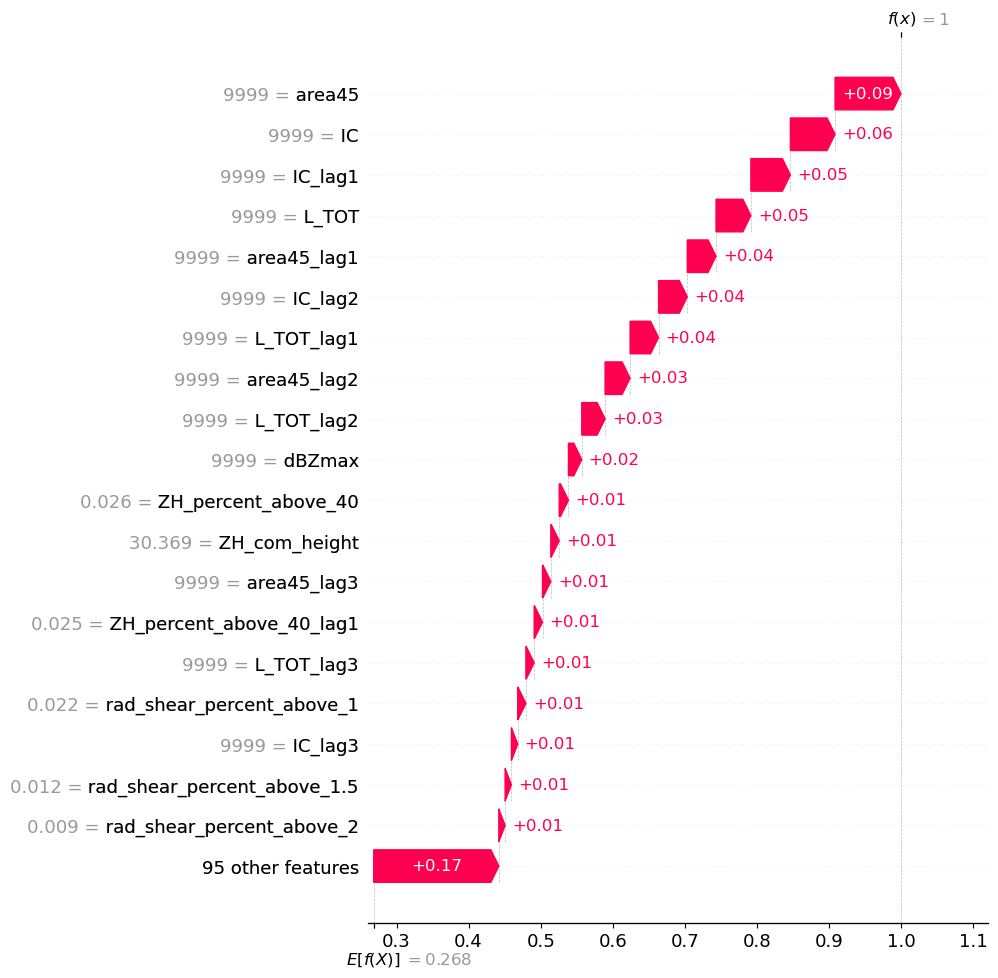

In [194]:


shap.plots.waterfall(shap_values[200, :, 1], max_display=20)
